# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [14]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.12.1+cu113
CUDA enabled: True


In [15]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [16]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [17]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [18]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    # TODO Add more preprocessing
    data = re.sub(r'[\r\n\t\s]+',' ', data)
    
    voc2ind = {}
    i = 0

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1

    train_size = int(len(data) * 0.8)

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:train_size]
    test_text = data[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [19]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens']
        voc2ind = dataset['voc2ind']

        batches = len(tokens) - len(tokens) % batch_size
        self.data = [voc2ind[tokens[i]] for i in range(batches)]
        self.data = torch.LongTensor(self.data).view(batch_size, -1)
        self.len = self.data.shape[0] * int(np.ceil((self.data.shape[1] - 1) / self.sequence_length))


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.len
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        seq_idx = idx // self.batch_size

        seq_start_idx = seq_idx * self.sequence_length
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, self.data.shape[1])

        data = self.data[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [20]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [21]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = output[0].argmax().long()
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
        outputs.append(sample)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = torch.multinomial(output[0], 1)[0].long()
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
        outputs.append(sample)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
        beams = []
        for c in beam:
            for sample in torch.multinomial(c[1][0], beam_width, replacement=True):
                sample = sample.long()
                score = c[3] + torch.log(c[1][0][sample])
                output, hidden = model.inference(sample, c[2], TEMPERATURE)
                beams.append((c[0] + [sample], output, hidden, score))
        beams.sort(key = lambda b: b[3], reverse=True)
        beam = beams[:beam_width]
    outputs = beam[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [22]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/logs/0.1/009.pt
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeat stlhttnd soaned ttain.t the soserseaisk  "I dm selri .  "e said  "Ion't yanky  war," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt r torer a

  1%|          | 1/195 [00:00<00:27,  7.10it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.356354


  7%|▋         | 13/195 [00:01<00:14, 12.26it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 2.007881


 12%|█▏        | 23/195 [00:01<00:13, 12.36it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.567003


 17%|█▋        | 33/195 [00:02<00:12, 12.52it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.458520


 22%|██▏       | 43/195 [00:03<00:12, 12.43it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.384248


 27%|██▋       | 53/195 [00:04<00:11, 12.50it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.354403


 32%|███▏      | 63/195 [00:05<00:10, 12.54it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.360388


 37%|███▋      | 73/195 [00:05<00:09, 12.40it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.352667


 43%|████▎     | 83/195 [00:06<00:08, 12.50it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.345831


 48%|████▊     | 93/195 [00:07<00:08, 12.47it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.351441


 53%|█████▎    | 103/195 [00:08<00:07, 12.50it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.363583


 58%|█████▊    | 113/195 [00:09<00:06, 12.43it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.347033


 63%|██████▎   | 123/195 [00:09<00:05, 12.42it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.359459


 68%|██████▊   | 133/195 [00:10<00:04, 12.41it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.377250


 73%|███████▎  | 143/195 [00:11<00:04, 12.33it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.369909


 78%|███████▊  | 153/195 [00:12<00:03, 12.30it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.366316


 84%|████████▎ | 163/195 [00:13<00:02, 12.31it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.350271


 89%|████████▊ | 173/195 [00:13<00:01, 12.24it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.351071


 94%|█████████▍| 183/195 [00:14<00:00, 12.17it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.341149


 99%|█████████▉| 193/195 [00:15<00:00, 12.24it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.364184


100%|██████████| 195/195 [00:15<00:00, 12.32it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troet shlntond sofded tnainst the sose  eohsk  "I tm shlri .  "e said  "Won't yhnsy  wot," said Herr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	ws d the stt r ohre  and terry se p d oumbledore seck on o the snk otet yer ahet horled hhe sooaede 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng htd soonpeng hn the soddle of the sork oeshthnooet on tagwmeade  "or tn  oewrible sorent oarry


Input	help, but there was nobody to be seen

  1%|          | 1/195 [00:00<00:36,  5.28it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.381942


  7%|▋         | 13/195 [00:01<00:15, 12.00it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.381464


 12%|█▏        | 23/195 [00:01<00:14, 12.26it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.356854


 17%|█▋        | 33/195 [00:02<00:13, 12.26it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.371453


 22%|██▏       | 43/195 [00:03<00:12, 12.37it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.359808


 27%|██▋       | 53/195 [00:04<00:11, 12.32it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.342169


 32%|███▏      | 63/195 [00:05<00:10, 12.23it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.356807


 37%|███▋      | 73/195 [00:06<00:09, 12.32it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.353888


 43%|████▎     | 83/195 [00:06<00:09, 12.26it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.340347


 48%|████▊     | 93/195 [00:07<00:08, 12.27it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.349393


 53%|█████▎    | 103/195 [00:08<00:07, 12.36it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.363412


 58%|█████▊    | 113/195 [00:09<00:06, 12.24it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.347179


 63%|██████▎   | 123/195 [00:10<00:05, 12.40it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.359015


 68%|██████▊   | 133/195 [00:10<00:05, 12.21it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.390208


 73%|███████▎  | 143/195 [00:11<00:04, 12.23it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.379801


 78%|███████▊  | 153/195 [00:12<00:03, 12.24it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.361832


 84%|████████▎ | 163/195 [00:13<00:02, 12.32it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.340836


 89%|████████▊ | 173/195 [00:14<00:01, 12.28it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.342552


 94%|█████████▍| 183/195 [00:14<00:00, 12.34it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.334427


 99%|█████████▉| 193/195 [00:15<00:00, 12.33it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.351630


100%|██████████| 195/195 [00:15<00:00, 12.20it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	troet shlntond sofded tnainst the sose  eoisk  "I tm shlr,..  "e said  "Iun't wansy  wot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed toe stt r ohrer and terry saap d oumbledore seck on o the snk otet yer aoen horled hoe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng hnd soonpeng hn the soddle of the sork oashthnoaeteon tagwmeade  "or tne oewrible torent harry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:28,  6.72it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.360281


  6%|▌         | 12/195 [00:01<00:15, 11.91it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.365296


 11%|█▏        | 22/195 [00:01<00:14, 12.16it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.353063


 16%|█▋        | 32/195 [00:02<00:13, 12.34it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.366720


 22%|██▏       | 42/195 [00:03<00:12, 12.35it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.354745


 27%|██▋       | 52/195 [00:04<00:11, 12.37it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.335249


 32%|███▏      | 62/195 [00:05<00:10, 12.26it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.350729


 37%|███▋      | 72/195 [00:05<00:09, 12.33it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.343316


 42%|████▏     | 82/195 [00:06<00:09, 12.38it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.330005


 47%|████▋     | 92/195 [00:07<00:08, 12.31it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.341390


 52%|█████▏    | 102/195 [00:08<00:07, 12.24it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.356706


 57%|█████▋    | 112/195 [00:09<00:06, 12.36it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.340134


 63%|██████▎   | 122/195 [00:10<00:05, 12.34it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.348920


 68%|██████▊   | 132/195 [00:10<00:05, 12.37it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.368435


 73%|███████▎  | 142/195 [00:11<00:04, 12.36it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.359011


 78%|███████▊  | 152/195 [00:12<00:03, 12.35it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.358240


 83%|████████▎ | 162/195 [00:13<00:02, 12.27it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.341141


 88%|████████▊ | 172/195 [00:14<00:01, 12.32it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.343134


 93%|█████████▎| 182/195 [00:14<00:01, 12.36it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.330539


 98%|█████████▊| 192/195 [00:15<00:00, 12.34it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.356030


100%|██████████| 195/195 [00:15<00:00, 12.19it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet shlntond sofded hnainst the sose  eoisk  "I wm shlri..  "e said  "Iun't wanky "wot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed toe stt r ohrer and sarry saap d oumbledore seck on o the snk otet yer aoan horled hoe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng hnd soonpeng hn the soddle of the sork oash hnoaem on tagwmeade  "or sne oewrible sorent harry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:28,  6.75it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.357199


  6%|▌         | 12/195 [00:01<00:15, 11.80it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.359516


 11%|█▏        | 22/195 [00:01<00:14, 12.29it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.340126


 16%|█▋        | 32/195 [00:02<00:13, 12.33it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.353763


 22%|██▏       | 42/195 [00:03<00:12, 12.32it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.343140


 27%|██▋       | 52/195 [00:04<00:11, 12.39it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.325224


 32%|███▏      | 62/195 [00:05<00:10, 12.23it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.345890


 37%|███▋      | 72/195 [00:06<00:10, 12.25it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.338003


 42%|████▏     | 82/195 [00:06<00:09, 12.37it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.321952


 47%|████▋     | 92/195 [00:07<00:08, 12.00it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.332413


 52%|█████▏    | 102/195 [00:08<00:07, 12.29it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.341016


 57%|█████▋    | 112/195 [00:09<00:06, 12.24it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.329927


 63%|██████▎   | 122/195 [00:10<00:06, 12.03it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.337029


 68%|██████▊   | 132/195 [00:10<00:05, 12.31it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.357829


 73%|███████▎  | 142/195 [00:11<00:04, 12.31it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.349539


 78%|███████▊  | 152/195 [00:12<00:03, 12.33it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.337612


 83%|████████▎ | 162/195 [00:13<00:02, 12.30it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.323830


 88%|████████▊ | 172/195 [00:14<00:01, 12.22it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.330570


 93%|█████████▎| 182/195 [00:14<00:01, 12.32it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.320251


 98%|█████████▊| 192/195 [00:15<00:00, 12.30it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.338969


100%|██████████| 195/195 [00:16<00:00, 12.14it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet shlntond soaved hnainst the sose  eaisk  "I wm shlr,..  "e said  "Iun't yanky "wot," said Herr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed toe stt r ohre  and serry saap d humbledore seck on o the sne otet yer aoan horled hhe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng hnd soonpeng hn hhe soddle of the sork oash hnoaem on tagwmeade  "or tne oewrible sorent harry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:29,  6.47it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.346675


  6%|▌         | 12/195 [00:01<00:15, 11.67it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.351964


 11%|█▏        | 22/195 [00:01<00:14, 11.94it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.335202


 16%|█▋        | 32/195 [00:02<00:13, 12.02it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.351207


 22%|██▏       | 42/195 [00:03<00:12, 12.10it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.336930


 27%|██▋       | 52/195 [00:04<00:11, 12.28it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.319002


 32%|███▏      | 62/195 [00:05<00:10, 12.30it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.339103


 37%|███▋      | 72/195 [00:06<00:09, 12.31it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.331249


 42%|████▏     | 82/195 [00:06<00:09, 12.30it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.316117


 47%|████▋     | 92/195 [00:07<00:08, 12.28it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.326113


 52%|█████▏    | 102/195 [00:08<00:07, 12.33it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.334073


 57%|█████▋    | 112/195 [00:09<00:06, 12.33it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.325378


 63%|██████▎   | 122/195 [00:10<00:05, 12.31it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.330015


 68%|██████▊   | 132/195 [00:10<00:05, 12.23it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.349828


 73%|███████▎  | 142/195 [00:11<00:04, 12.23it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.344023


 78%|███████▊  | 152/195 [00:12<00:03, 12.36it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.331646


 83%|████████▎ | 162/195 [00:13<00:02, 12.30it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.315826


 88%|████████▊ | 172/195 [00:14<00:01, 12.23it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.323465


 93%|█████████▎| 182/195 [00:15<00:01, 12.30it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.315214


 98%|█████████▊| 192/195 [00:15<00:00, 12.08it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.335814


100%|██████████| 195/195 [00:16<00:00, 12.11it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet shlntond soavid onainst the sose  eaisk  "I wm shlr,..  "e said  "Iun't yanky "wot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed toe stt r ohre  and serry saap d humbledore seck in o the sne otet yer aoan horled hhe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng hnd soonpeng hn hhe soddle of the sork oaghthnoaem on tagwmeade  "or sne oeurible sorent harry


Input	help, but there was nobody to be seen

  1%|          | 1/195 [00:00<00:36,  5.31it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.343051


  6%|▌         | 12/195 [00:01<00:15, 11.81it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.345663


 11%|█▏        | 22/195 [00:01<00:14, 12.22it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.327686


 16%|█▋        | 32/195 [00:02<00:13, 12.10it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.343689


 22%|██▏       | 42/195 [00:03<00:12, 12.10it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.330285


 27%|██▋       | 52/195 [00:04<00:11, 12.11it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.312807


 32%|███▏      | 62/195 [00:05<00:10, 12.12it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.331315


 37%|███▋      | 72/195 [00:06<00:09, 12.32it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.325035


 42%|████▏     | 82/195 [00:06<00:09, 12.26it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.312699


 47%|████▋     | 92/195 [00:07<00:08, 12.26it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.320486


 52%|█████▏    | 102/195 [00:08<00:07, 12.21it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.328919


 57%|█████▋    | 112/195 [00:09<00:06, 12.22it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.319335


 63%|██████▎   | 122/195 [00:10<00:06, 12.01it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.324438


 68%|██████▊   | 132/195 [00:10<00:05, 12.10it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.343992


 73%|███████▎  | 142/195 [00:11<00:04, 12.13it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.336895


 78%|███████▊  | 152/195 [00:12<00:03, 12.23it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.328066


 83%|████████▎ | 162/195 [00:13<00:02, 12.29it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.310095


 88%|████████▊ | 172/195 [00:14<00:01, 12.36it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.313449


 93%|█████████▎| 182/195 [00:15<00:01, 12.08it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.307708


 98%|█████████▊| 192/195 [00:15<00:00, 12.19it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.329873


100%|██████████| 195/195 [00:16<00:00, 12.06it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	soeet shlntond soavid onainst the sose  eaisk  "I wm shlr,..  "e said  "Ion't yanky "wot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt r ohre  and sarry saap d humbledore seck in o the sne otet yer aoan hlrled hhe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ereng hnd soonpeng hn hhe soddle of the sork waghthnoaem on tagwmeade  "or sn  oeurible sorent harry


Input	help, but there was nobody to be seen

  2%|▏         | 3/195 [00:00<00:22,  8.54it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.337729


  7%|▋         | 13/195 [00:01<00:15, 11.86it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.336143


 12%|█▏        | 23/195 [00:02<00:13, 12.30it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.321884


 17%|█▋        | 33/195 [00:02<00:13, 12.10it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.338230


 22%|██▏       | 43/195 [00:03<00:12, 12.19it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.325062


 27%|██▋       | 53/195 [00:04<00:11, 12.19it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.308606


 32%|███▏      | 63/195 [00:05<00:10, 12.29it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.326096


 37%|███▋      | 73/195 [00:06<00:09, 12.25it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.319998


 43%|████▎     | 83/195 [00:06<00:09, 12.23it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.310345


 48%|████▊     | 93/195 [00:07<00:08, 12.05it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.315376


 53%|█████▎    | 103/195 [00:08<00:07, 12.25it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.324375


 58%|█████▊    | 113/195 [00:09<00:06, 12.36it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.309033


 63%|██████▎   | 123/195 [00:10<00:05, 12.27it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.318645


 68%|██████▊   | 133/195 [00:11<00:05, 12.10it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.340420


 73%|███████▎  | 143/195 [00:11<00:04, 12.28it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.331037


 78%|███████▊  | 153/195 [00:12<00:03, 12.14it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.324862


 84%|████████▎ | 163/195 [00:13<00:02, 12.15it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.306393


 89%|████████▊ | 173/195 [00:14<00:01, 12.16it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.309036


 94%|█████████▍| 183/195 [00:15<00:00, 12.20it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.303222


 99%|█████████▉| 193/195 [00:15<00:00, 12.11it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.326242


100%|██████████| 195/195 [00:16<00:00, 12.10it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	soeet shlntond soavid onainst the sose  eaisk  "I wm shlr,..  "e said  "Ion't yanky "wot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt r ohre  and sarry saap d humbledore seck in o the sne ohet yer aoan hlrled hhe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering htd soonpeng hn hhe soddle of the sork waghthnoaem on tagwmeade  "or sf  seurible sorent harry


Input	help, but there was nobody to be seen

  2%|▏         | 3/195 [00:00<00:22,  8.44it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.333307


  7%|▋         | 13/195 [00:01<00:15, 11.96it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.329025


 12%|█▏        | 23/195 [00:02<00:14, 12.24it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.318518


 17%|█▋        | 33/195 [00:02<00:13, 12.06it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.333445


 22%|██▏       | 43/195 [00:03<00:12, 12.21it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.320270


 27%|██▋       | 53/195 [00:04<00:11, 12.25it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.306011


 32%|███▏      | 63/195 [00:05<00:10, 12.20it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.322757


 37%|███▋      | 73/195 [00:06<00:10, 12.16it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.316889


 43%|████▎     | 83/195 [00:06<00:09, 12.17it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.306443


 48%|████▊     | 93/195 [00:07<00:08, 12.01it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.311151


 53%|█████▎    | 103/195 [00:08<00:07, 12.03it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.320982


 58%|█████▊    | 113/195 [00:09<00:06, 12.01it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.303581


 63%|██████▎   | 123/195 [00:10<00:05, 12.09it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.314241


 68%|██████▊   | 133/195 [00:11<00:05, 12.27it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.337216


 73%|███████▎  | 143/195 [00:11<00:04, 12.22it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.328319


 78%|███████▊  | 153/195 [00:12<00:03, 12.13it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.320436


 84%|████████▎ | 163/195 [00:13<00:02, 12.27it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.303882


 89%|████████▊ | 173/195 [00:14<00:01, 12.17it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.305669


 94%|█████████▍| 183/195 [00:15<00:00, 12.25it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.300324


 99%|█████████▉| 193/195 [00:15<00:00, 12.01it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.324883


100%|██████████| 195/195 [00:16<00:00, 12.05it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet shlntond soavid tnainst the sose  oaisk  "I wm selr,..  "e said  "Ion't yanky  wot," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt r ohre  and sarry saad d humbledore seck in o the sne ohct yer aoat hlrled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering htd soonpeng hn hhe soddle of the sork waghtanoaem on tagwmeade  "or sf  seurible sorent harry


Input	help, but there was nobody to be seen

  1%|          | 2/195 [00:00<00:28,  6.68it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.328832


  6%|▌         | 12/195 [00:01<00:15, 11.87it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.323528


 11%|█▏        | 22/195 [00:01<00:14, 12.05it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.316936


 16%|█▋        | 32/195 [00:02<00:13, 12.07it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.329944


 22%|██▏       | 42/195 [00:03<00:12, 12.15it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.317546


 27%|██▋       | 52/195 [00:04<00:11, 12.25it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.304166


 32%|███▏      | 62/195 [00:05<00:10, 12.29it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.319770


 37%|███▋      | 72/195 [00:06<00:09, 12.33it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.312546


 42%|████▏     | 82/195 [00:06<00:09, 12.10it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.301677


 47%|████▋     | 92/195 [00:07<00:09, 11.04it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.308156


 52%|█████▏    | 102/195 [00:08<00:08, 11.28it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.318894


 57%|█████▋    | 112/195 [00:09<00:06, 11.98it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.302274


 63%|██████▎   | 122/195 [00:10<00:06, 11.76it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.313253


 68%|██████▊   | 132/195 [00:11<00:05, 11.44it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.330454


 73%|███████▎  | 142/195 [00:12<00:04, 11.93it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.326001


 78%|███████▊  | 152/195 [00:12<00:03, 11.84it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.317477


 83%|████████▎ | 162/195 [00:13<00:02, 11.82it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.302378


 88%|████████▊ | 172/195 [00:14<00:01, 11.87it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.299857


 93%|█████████▎| 182/195 [00:15<00:01, 12.14it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.299536


 98%|█████████▊| 192/195 [00:16<00:00, 12.07it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.319821


100%|██████████| 195/195 [00:16<00:00, 11.84it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet shlntond soaved atainst the sase soaisk  "I wm selr,".  "e said  "Ion't yanky  wor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt r ohre  and sarry saad d humbledore seck in o the sne otct yer aoat hlrled the sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering htd soonpeng hn the coddle of the sork waghtanuaem on tagwmeade  "or af  seurible serent aarry


Input	help, but there was nobody to be seen

  2%|▏         | 3/195 [00:00<00:24,  7.99it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.323177


  7%|▋         | 13/195 [00:01<00:15, 11.68it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.321293


 12%|█▏        | 23/195 [00:02<00:14, 11.82it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.315935


 17%|█▋        | 33/195 [00:02<00:13, 12.00it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.326034


 22%|██▏       | 43/195 [00:03<00:12, 12.20it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.317063


 27%|██▋       | 53/195 [00:04<00:11, 12.04it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.302219


 32%|███▏      | 63/195 [00:05<00:10, 12.12it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.316229


 37%|███▋      | 73/195 [00:06<00:10, 12.11it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.308664


 43%|████▎     | 83/195 [00:07<00:09, 12.21it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.298366


 48%|████▊     | 93/195 [00:07<00:08, 12.15it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.306159


 53%|█████▎    | 103/195 [00:08<00:07, 12.29it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.316250


 58%|█████▊    | 113/195 [00:09<00:06, 12.21it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.301203


 63%|██████▎   | 123/195 [00:10<00:05, 12.12it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.312871


 68%|██████▊   | 133/195 [00:11<00:05, 12.15it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.325920


 73%|███████▎  | 143/195 [00:11<00:04, 12.26it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.324333


 78%|███████▊  | 153/195 [00:12<00:03, 12.10it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.315499


 84%|████████▎ | 163/195 [00:13<00:02, 12.25it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.300572


 89%|████████▊ | 173/195 [00:14<00:01, 12.08it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.295136


 94%|█████████▍| 183/195 [00:15<00:00, 12.13it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.296454


 99%|█████████▉| 193/195 [00:16<00:00, 12.07it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.315072


100%|██████████| 195/195 [00:16<00:00, 12.01it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet shlntand soaved atainst the sase soaisl  "I wm selri".  "e said  "Ion't tanky  wor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt riohre  and sarry saaded aumbledore seck in o the sne otcteyer aoat hlrled ahe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soonpeng hn the coddle of the sork waghtanoaem on tagwmeade  "rr af  seurible serent aarry


Input	help, but there was nobody to be seen

  2%|▏         | 3/195 [00:00<00:24,  7.97it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.321265


  7%|▋         | 13/195 [00:01<00:15, 11.55it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.319214


 12%|█▏        | 23/195 [00:02<00:14, 11.96it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.314216


 17%|█▋        | 33/195 [00:02<00:13, 12.20it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.323412


 22%|██▏       | 43/195 [00:03<00:12, 12.14it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.315431


 27%|██▋       | 53/195 [00:04<00:11, 12.05it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.300372


 32%|███▏      | 63/195 [00:05<00:11, 11.92it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.312834


 37%|███▋      | 73/195 [00:06<00:10, 12.08it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.307134


 43%|████▎     | 83/195 [00:07<00:09, 12.19it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.295729


 48%|████▊     | 93/195 [00:07<00:08, 12.13it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.305670


 53%|█████▎    | 103/195 [00:08<00:07, 12.17it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.313704


 58%|█████▊    | 113/195 [00:09<00:06, 12.15it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.299327


 63%|██████▎   | 123/195 [00:10<00:05, 12.13it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.310814


 68%|██████▊   | 133/195 [00:11<00:05, 12.27it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.322923


 73%|███████▎  | 143/195 [00:11<00:04, 12.13it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.322454


 78%|███████▊  | 153/195 [00:12<00:03, 12.02it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.314225


 84%|████████▎ | 163/195 [00:13<00:02, 11.95it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.297991


 89%|████████▊ | 173/195 [00:14<00:01, 12.04it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.291780


 94%|█████████▍| 183/195 [00:15<00:01, 11.83it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.294042


 99%|█████████▉| 193/195 [00:16<00:00, 11.91it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.313245


100%|██████████| 195/195 [00:16<00:00, 11.93it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	tooet sulntand soaved atainst the sase soaisl  "I wm selri".  "e said  "Ion't tanky  wor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt riohre  and sarry saaded aumbledore seck in o the sne otcteyer aoat hlrled ahe sooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soonpeng hn the coddle of the sork waghtanoaem an tagwmeade  "rr af  seurible aerent aarry


Input	help, but there was nobody to be seen

  0%|          | 0/195 [00:00<?, ?it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.320919

  2%|▏         | 3/195 [00:00<00:22,  8.67it/s]

  7%|▋         | 13/195 [00:01<00:15, 11.66it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.317747


 12%|█▏        | 23/195 [00:02<00:14, 12.26it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.313054


 17%|█▋        | 33/195 [00:02<00:13, 11.96it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.322193


 22%|██▏       | 43/195 [00:03<00:13, 11.65it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.313082


 27%|██▋       | 53/195 [00:04<00:11, 11.89it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.298324


 32%|███▏      | 63/195 [00:05<00:11, 12.00it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.310710


 37%|███▋      | 73/195 [00:06<00:10, 11.86it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.305944


 43%|████▎     | 83/195 [00:07<00:09, 11.70it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.293960


 48%|████▊     | 93/195 [00:07<00:08, 12.10it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.305486


 53%|█████▎    | 103/195 [00:08<00:07, 12.13it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.311560


 58%|█████▊    | 113/195 [00:09<00:06, 11.91it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.298040


 63%|██████▎   | 123/195 [00:10<00:06, 11.94it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.308738


 68%|██████▊   | 133/195 [00:11<00:05, 11.91it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.321580


 73%|███████▎  | 143/195 [00:12<00:04, 12.05it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.321125


 78%|███████▊  | 153/195 [00:12<00:03, 11.97it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.314033


 84%|████████▎ | 163/195 [00:13<00:02, 12.25it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.296608


 89%|████████▊ | 173/195 [00:14<00:01, 12.11it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.289483


 94%|█████████▍| 183/195 [00:15<00:00, 12.02it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.292656


 99%|█████████▉| 193/195 [00:16<00:00, 11.98it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.312248


100%|██████████| 195/195 [00:16<00:00, 11.89it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Harr
pred	toeet sulntand soaved atainst the sase soaisl  "I wm aelri".  "e said  "Ion't tarky  wor," said Harr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice 
pred	wsed the stt riohre  and sarry saaded aumbledore aeck in o the cne otcteyer aoat hlrled ahe cooaeoe 


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harry
pred	ering atd soonpeng hn ahe coddle of the cork aaghtanoaem an tagwmeade  "rr af  seurible aorent aarry


Input	help, but there was nobody to be seen

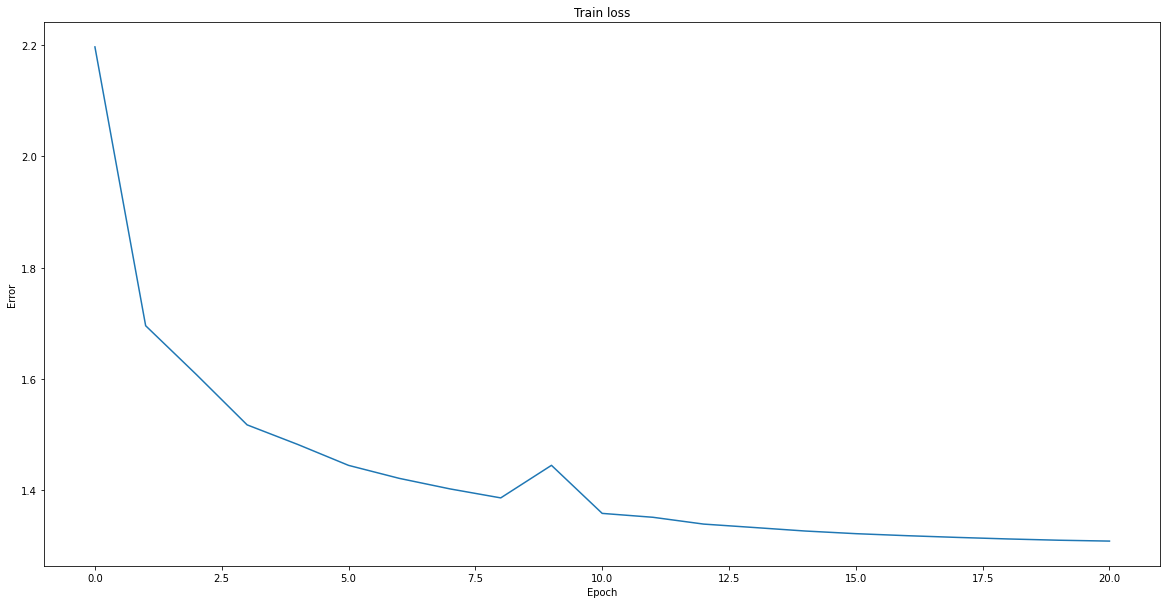

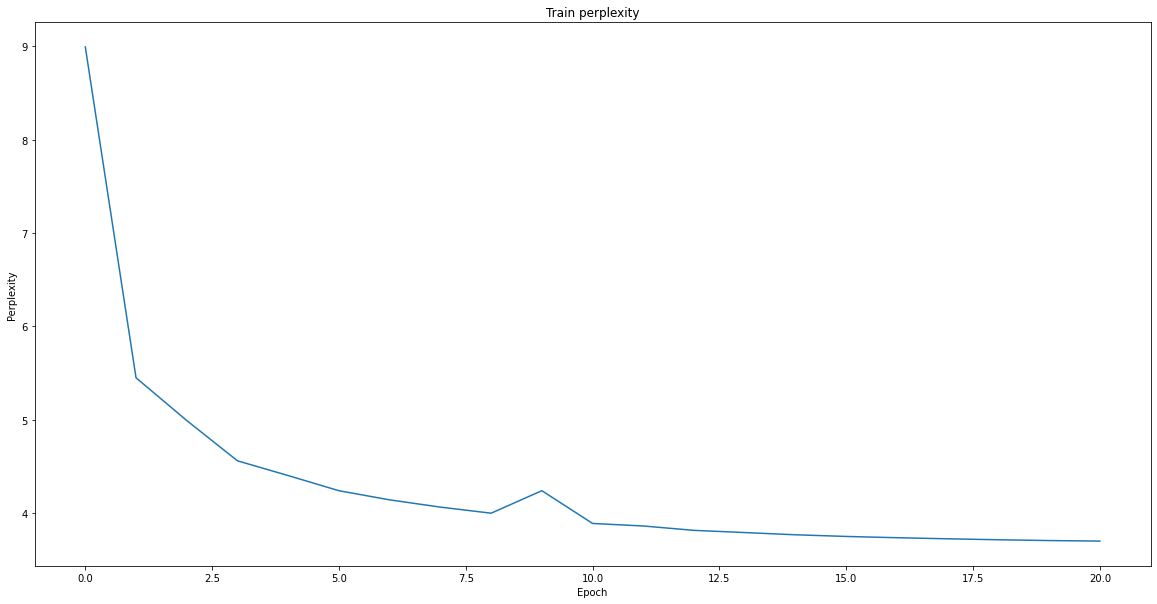

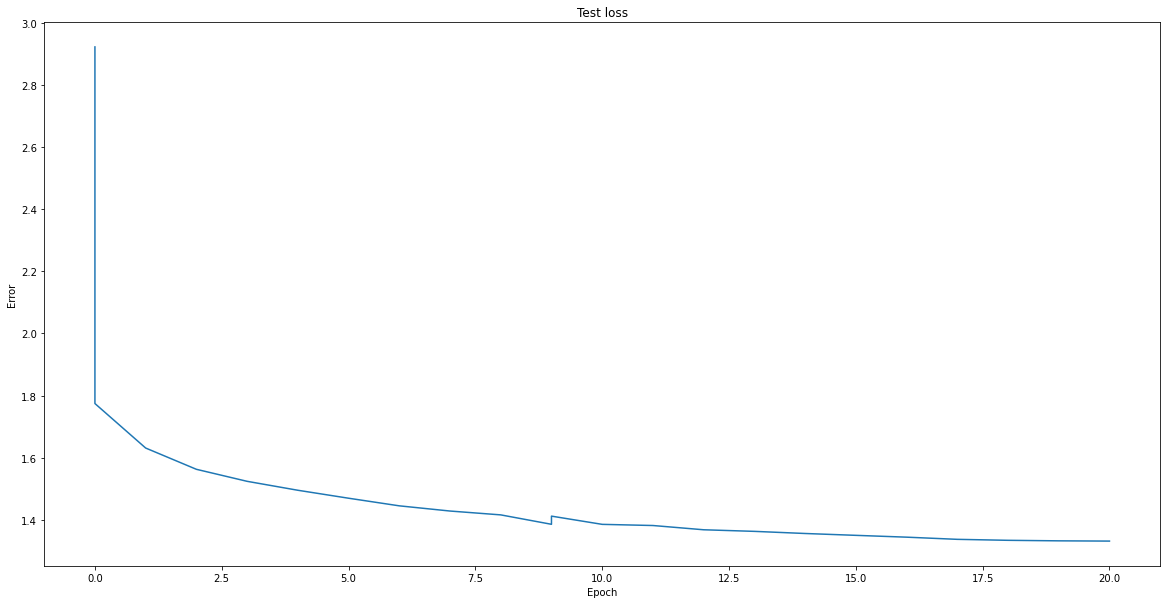

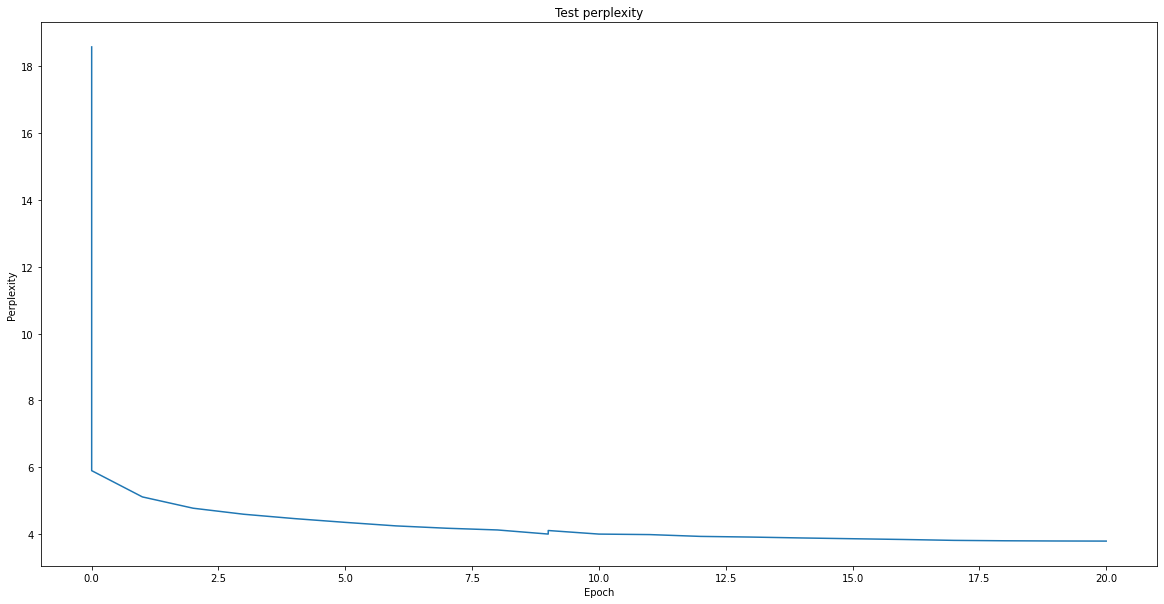

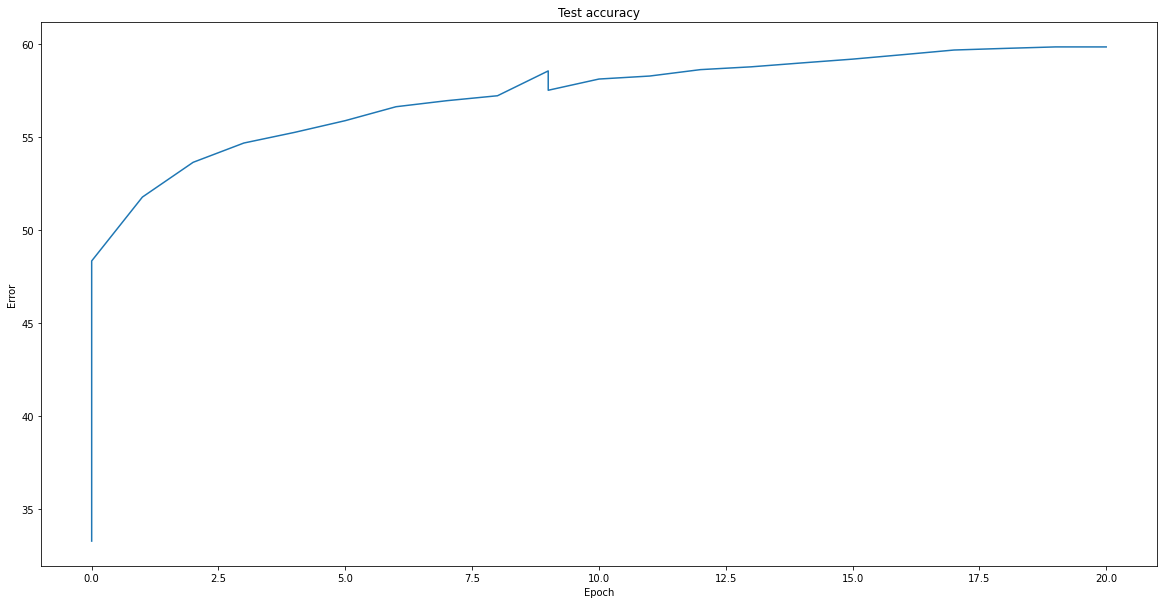

Final test accuracy: 59.86065051020408
Final test perplexity: 3.7871299876677127


In [23]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/' + VERSION + '/'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [24]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry laughed'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry laughed and said, "I think you were all the other to the common room when he was all the staff and said and slightly as the other side of the corner of the corner of the corner of the corner of the corner of
generated with sample	 Harry laughed. "It's a good bite metables and in the school of the small for the room closed to be a tiny of the last was all watch Harry and bed at the centach and she was so that he could hear mere under at the 
generated with sample	 Harry laughed a lot of the mirror and began to the partice expell and disappeared into the silven taken the corridors and she was only and stared at the silence of the door with his wand and slammed at him. "Not a
generated with sample	 Harry laughed and looked a letter of the states of the library of the particularly feet and returned at Harry and pulled his long from the suspicious was a started to his feet and feeling the carriage suddenly to 
generated with sample	 Harry laughed. "Yeah, were enoug

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



## 8.1: Train on the Bee Movie

In [25]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'beemovie.txt')):
    os.chdir(BASE_PATH)
    !cp beemovie.txt /content
os.chdir('/content')

In [26]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()

    # TODO Add more preprocessing
    data = re.sub(r'[\r\n\t\s]+',' ', data)
    
    voc2ind = {}
    i = 0

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
            voc2ind[char] = i
            i += 1

    train_size = int(len(data) * 0.8)

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:train_size]
    test_text = data[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'beemovie_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'beemovie_chars_test.pkl', 'wb'))

prepare_data(DATA_PATH + 'beemovie.txt')

Using device cuda
num workers: 2
Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	A:4"V??:x???Ahxm?e..9..5, a:1"K:::UkkG



Test set: Average loss: 16.3630, Accuracy: 75/25600 (0%)



100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

Train Epoch: 0 [0/512 (0%)]	Loss: 16.400547


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	ttseet teeetThiieen.nnnel  ate teteneG



Test set: Average loss: 9.3414, Accuracy: 977/25600 (4%)

Saved /content/logs/beemovie/0.1/000.pt

generated max		 According to all known laws of aviation, tteeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 According to all known laws of aviation, tteeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
generated sample	 According to all known laws of aviation, tteeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee

100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

Train Epoch: 1 [0/512 (0%)]	Loss: 9.403501


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 byrc  -yac T-iinmngg,nll  llr I Iool 



Test set: Average loss: 6.5127, Accuracy: 1984/25600 (8%)

Saved /content/logs/beemovie/0.1/001.pt

generated max		 According to all known laws of aviation, /uur Imen ou Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Inec. I Ine
generated sample	 According to all known laws of aviation, /uukig bhallllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll
generated sample	 According to all known laws of aviation, liign halllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll

100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

Train Epoch: 2 [0/512 (0%)]	Loss: 6.545731


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	!aef.. Ty... Tfinmt g,tti  Ie  T kok y



Test set: Average loss: 5.7938, Accuracy: 2379/25600 (9%)

Saved /content/logs/beemovie/0.1/002.pt

generated max		 According to all known laws of aviation, warr falit hes. The. you warry I kilow arryou warry I kilow arryou warry I kilow arryou warry I kilow arryou warry I kilow arryou warry I kilow arryou warry I kilow arryou warry I kilow arryou warry I
generated sample	 According to all known laws of aviation,  warryu I kwNhe, ber fyou warryou warr fat ikivP flou warry I kilom fallits akivllkit hes. Theyo. Ofat ikivPEEEEEEKrs faryou warry are nowat he. I I kwNhe, I AavBllit hes. your I kwNhe, Oathes. pbe lo
generated sample	 According to all known laws of aviation, warrre you warry arre arry eno. warry I Aallit hes. your I king hat hes. The. Theyou warry bef lou dond you I kwe aryou warry ure nowe benyou warry be arryou warry arre me your nes. The. yo

 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]

Train Epoch: 3 [0/512 (0%)]	Loss: 5.810124


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	!penn. Te.,! TAinmt tttt   Oe  T Aon t



Test set: Average loss: 5.1675, Accuracy: 2344/25600 (9%)

generated max		 According to all known laws of aviation, be coom's! neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou neyou ney
generated sample	 According to all known laws of aviation, w hato kwNhatsis! neyou', w hatise comon's patits! hem. Thatistisk hatistis! he coon't we bef Thou's! ney watistisk hatistisk her, Oatit coon't watisthe coon't fit he coomon't watistis! ney, Ohenthe c
generated sample	 According to all known laws of aviation, w hatis AvBe, lit her, Ocon't watits akit coon't wat kit hat coon't watist kive colome neyou neyou neyou's pentistis, be lof lof Ohen't we bef6you neyou', be loff Ohenos. O'pKs! engo. le coon's! Whe, 
generated sample	 According t

 50%|█████     | 1/2 [00:00<00:00,  5.29it/s]

Train Epoch: 4 [0/512 (0%)]	Loss: 5.068989


100%|██████████| 2/2 [00:00<00:00,  6.43it/s]


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	eWelre Werr! TAenmt nt     u   W Aon '



Test set: Average loss: 4.4284, Accuracy: 2523/25600 (10%)

Saved /content/logs/beemovie/0.1/004.pt

generated max		 According to all known laws of aviation, be lit lak ve have ve! ing ut and and? Yo uple lit lak ve have ve! ing ut and and? Yo uple lit lak ve have ve! ing ut and and? Yo uple lit lak ve have ve! ing ut and and? Yo uple lit lak ve have ve! i
generated sample	 According to all known laws of aviation,  uca colding ut a cood and? Yo uple lit and and? Yo uding ut' ma be roud. ra coodin't ica cood and? Tha could it erasit cad inta cood pabe lit era coodin't frint a colding. Whuj? Y Ave here int' s uco
generated sample	 According to all known laws of aviation, ut cold andy uple int' rit cad int' se reingo bele ingto lak enose! y uple int' se roud pandsiting. Whuj? Yo udit' Tha cood ak vely witl ave ve! he int' se rering. Whuj? Yo udingto kin't c

100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

Train Epoch: 5 [0/512 (0%)]	Loss: 4.365698


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	tBolle Well? BAetal nl     waa Y tons'



Test set: Average loss: 4.0163, Accuracy: 2613/25600 (10%)

Saved /content/logs/beemovie/0.1/005.pt

generated max		 According to all known laws of aviation,  there sthere sose! go sthere sthere sose! go sthere sthere sose! go sthere sthere sose! go sthere sthere sose! go sthere sthere sose! go sthere sthere sose! go sthere sthere sose! go sthere sthere so
generated sample	 According to all known laws of aviation, Bellet..................................................................................................................................................................................................
generated sample	 According to all known laws of aviation, bo tall yenesetlelle the theresse! ing there sose! Hose! go so sthere.......................................................................................................................

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

Train Epoch: 6 [0/512 (0%)]	Loss: 3.968253


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	uHuaae Iear? BAetal llll   waa Itton! 



Test set: Average loss: 3.7377, Accuracy: 3002/25600 (12%)

Saved /content/logs/beemovie/0.1/006.pt

generated max		 According to all known laws of aviation, whis the thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will whis thin will w
generated sample	 According to all known laws of aviation, bute the the the mean? - You the the mean is the meano thin the this thume this thumen on thime an oney whis the thin will will the thin will thin thin thin a the thin thims Ball, whis the thin will i
generated sample	 According to all known laws of aviation, Beall, whis thin will thin willl we hay bout dony will whin the thy were thin will whis thin ywir thin whin to man ong to we his thin will thin will whis this thin will thin wichave the th

100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

Train Epoch: 7 [0/512 (0%)]	Loss: 3.706865


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	uHueau Suar? Boeradfnkkl   wea S'Ion!'



Test set: Average loss: 3.5168, Accuracy: 2967/25600 (12%)

generated max		 According to all known laws of aviation, what donking. - I'mmesuss, arry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry porry 
generated sample	 According to all known laws of aviation, buche off? - Ghis feere ghumpearry wearry beall were hary buchat dan? - porry anis, whis sourr youpll - Barry. - ghumans, icank offidrry, Barry, his susche oun you porry aprearle what sour your you po
generated sample	 According to all known laws of aviation, d angamese arr day, what donkid! I'mme anis an arry oupll wearry porry, what da! We'r ghumins anoke off? - IMaPmumean arre arry oung, maning, manis an, what donki! guman, buchat don? I IMang? - gupll 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

Train Epoch: 8 [0/512 (0%)]	Loss: 3.505113


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	uHuesu Sursu Ioerqdffkkl   Wis S'don!'



Test set: Average loss: 3.2056, Accuracy: 3193/25600 (12%)

Saved /content/logs/beemovie/0.1/008.pt

generated max		 According to all known laws of aviation, bicot don yow! Wes arry pot ffor you don. We. SAn. Sot don yow! Wes arry pot ffor you don. We. SAn. Sot don yow! Wes arry pot ffor you don. We. SAn. Sot don yow! Wes arry pot ffor you don. We. SAn. So
generated sample	 According to all known laws of aviation, bicke How! Wes our ghthe bee sus. That and feesuss. Sourn yow. SAn. Sou the red ipes. Sou not for you pot fot the you bee beesuss, sopry. That then ing ing. Wees Heses an you bee pot fe. Sot dond you 
generated sample	 According to all known laws of aviation, s ou pot for the dowes. Sot the the dowes arrype. Sour you don you pot this is an ines, is your beesuss. Sot not this schat's a fot the red pot fere pot ffor dower dow! Weshe sus. Sot bee?

100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

Train Epoch: 9 [0/512 (0%)]	Loss: 3.191771


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	.all   Tulr  Ioerqrofkkl   co  T done'



Test set: Average loss: 3.0852, Accuracy: 3258/25600 (13%)

Saved /content/logs/beemovie/0.1/009.pt

generated max		 According to all known laws of aviation, lifet? The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t
generated sample	 According to all known laws of aviation, liffowre. An on the the blow. An your yourlowast an an lowathe the be thot tatist an to the this ave prey. The was a pered wast tating the your coot the the the this a the bee bulome. An you not the t
generated sample	 According to all known laws of aviation, lingetingi! n I'm moun. An. We. An. An on the rito the the this a nlowastirk. The your the the this an lowastating ere. The waht to the was an a lowit! We And you love the this am a the th

100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

Train Epoch: 10 [0/512 (0%)]	Loss: 3.035436


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 aee   Turr! Ioererofkne   cyy A cone'



Test set: Average loss: 2.9636, Accuracy: 3228/25600 (13%)

generated max		 According to all known laws of aviation, s a culesen are coules an a coulese jus. - Well hove ritating ing iten, riting ing iten, riting ing iten, riting ing iten, riting ing iten, riting ing iten, riting ing iten, riting ing iten, riting in
generated sample	 According to all known laws of aviation, be coulderey birtis. - WMarey couldere? Noove ritall an iten an an wase jusing ing ere was a culles an an a neerey coulderse was a can's a celles was an there? Noo this in ing oney coursell, shere war
generated sample	 According to all known laws of aviation, ling sen't lifere coures! y yourritaly. And your sellovie was a celow. I colove ba liend to be buced be jus your scelove ba coulers! The's lovie son loney! I scoled jus. They's a ie an honey? - Oculde
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

Train Epoch: 11 [0/512 (0%)]	Loss: 2.867213


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	!hee   -u,,! Ieetenofkn    hyy Y done'



Test set: Average loss: 2.8162, Accuracy: 3409/25600 (13%)

Saved /content/logs/beemovie/0.1/011.pt

generated max		 According to all known laws of aviation, stiront the wours! - Oh, what the was have warse woor sthe wor hove wor honey can't to bee cuplest ito sthing it wint the wours! - Oh, what the was have warse woor sthe wor hove wor honey can't to bee
generated sample	 According to all known laws of aviation, thoonese, hor scees areay cito site, nd to bee cuples whoontey, hand to with wit with wit ther was doow.................................................................................................
generated sample	 According to all known laws of aviation, sto with wit the was doodey? Yeel hoonet! I sMamacre coulders! - Ocuples! I don't to goonte, sto do good dodey? - Mrit this will ghe to be coun't to don't the wood dood bee cou selel, hres

 50%|█████     | 1/2 [00:00<00:00,  5.25it/s]

Train Epoch: 12 [0/512 (0%)]	Loss: 2.692304


100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	thee   Iee,! Ieetenllknl   tya Y dade'



Test set: Average loss: 2.7204, Accuracy: 3473/25600 (14%)

Saved /content/logs/beemovie/0.1/012.pt

generated max		 According to all known laws of aviation, sto all the mee the mee and to abre the mee the mee and to abre the mee the mee and to abre the mee the mee and to abre the mee the mee and to abre the mee the mee and to abre the mee the mee and to a
generated sample	 According to all known laws of aviation, ste, arudead dof it the mak ito sthre parud's the wee cand the and to blight it. OKenand to stear, heres! Seet an the won to all the mectakn't to able there inte, are makn to alk ite tall this gonet, 
generated sample	 According to all known laws of aviation, din't to likn to all are meakn of ite the are of are apre tof you dad's don there sto ar papecees! Oor pint. I kn. Bee, just will the makn to all the beead. Oo, netes! Oupt it will gut tha

100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

Train Epoch: 13 [0/512 (0%)]	Loss: 2.615524


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 hoe   Ieen, Ieeetnllhsl   tac Itdin '



Test set: Average loss: 2.6300, Accuracy: 3409/25600 (13%)

generated max		 According to all known laws of aviation, sor pipestick of is humans on a pill thing bees on a pill thing bees on a pill thing bees on a pill thing bees on a pill thing bees on a pill thing bees on a pill thing bees on a pill thing bees on a 
generated sample	 According to all known laws of aviation, casall one think is is huall gorste ones onen. I son't lle sturencerensons! rou mall ite bee ban for sthing you pin fllys is hu're flly thing ones! I'm know. It's mall this his hat frome son ar his wi
generated sample	 According to all known laws of aviation, son all thing bees! I scupp. - Whattat? I know hat to a pill thing making of in ther. Been humans hone sone! I Oh, Istu'll bre thing is hat. Mougrstighis is in know. I know as didi? GGking his hat to 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

Train Epoch: 14 [0/512 (0%)]	Loss: 2.535504


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 woe   Tees, See tnllhsl   tat Tttann'



Test set: Average loss: 2.5174, Accuracy: 3639/25600 (14%)

Saved /content/logs/beemovie/0.1/014.pt

generated max		 According to all known laws of aviation, a some the make to a sture onen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen an a here wen 
generated sample	 According to all known laws of aviation, rout think ing how one. I don't a bee be to ba the oney? necte of the mere the oney, an there the were fore man a ppill there me. What to we there pan conen. Hon you this what there we hat the mecreti
generated sample	 According to all known laws of aviation, bout the beecre one! - How now! What to a hat the mere bee! TT'll re the make on ta the man. How here one stery, your your a forry, your now hat werecte of the mat it live non. Home thing.

100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

Train Epoch: 15 [0/512 (0%)]	Loss: 2.421975


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 weess Teess See inelhsl   tat T tone'



Test set: Average loss: 2.4409, Accuracy: 3721/25600 (15%)

Saved /content/logs/beemovie/0.1/015.pt

generated max		 According to all known laws of aviation, buzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
generated sample	 According to all known laws of aviation, bucresssalod ou the wed that to sa theme to mabloto so mall thing. - Hom litging. - Sapte and to but of that is this what the ith wer. My. Arday the you this hover. - Holown. - How salow that a sa to 
generated sample	 According to all known laws of aviation, now It's a scase forry, you lome? Gin hat gotime. Thinke come the ine! Tall oright on the sme! - That's got to sa dow th an you lito do my eall to smo that ta hat wan hat some the even and

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

Train Epoch: 16 [0/512 (0%)]	Loss: 2.333028


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 heess -ees, Iee itelhsl   yet I done'



Test set: Average loss: 2.3964, Accuracy: 3765/25600 (15%)

Saved /content/logs/beemovie/0.1/016.pt

generated max		 According to all known laws of aviation, buzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
generated sample	 According to all known laws of aviation, cometing beesssader werd eit o this come this coppping. The it sting it san ther. - coming usee honey? - I scan't here? Se And coney seess, beessuss! - He've gon to bee beid susider what semeting hot 
generated sample	 According to all known laws of aviation, buzzzzzzzzzzzzz49Kre Keand the an ware. And just is hever. I that see have honey. I don't case have sare and josuld hovery. I don't ge theme stinging! us not for this? - I'm got that seema

100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

Train Epoch: 17 [0/512 (0%)]	Loss: 2.268993


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   Iees, See ilelhsl   yyt Y tone'



Test set: Average loss: 2.3699, Accuracy: 3778/25600 (15%)

Saved /content/logs/beemovie/0.1/017.pt

generated max		 According to all known laws of aviation, buzzzzzzzzz49Kre an the are and the are and the are and the are and the are and the are and the are and the are and the are and the are and the are and the are and the are and the are and the are and 
generated sample	 According to all known laws of aviation, quet that packe don't a for theme the senthere don't re don't cant don't do the hose are not pout for of there the want wasy the sarme the was the you honey. - I'm got that a pare and what's don't do 
generated sample	 According to all known laws of aviation, buzzzzzzzzz49Krenst of the are and bee the are was the are honey for ris the as hoe! I was that pande are fall bee that you Not........ Yoo goot............ Yee ah................. Yea, ma

 50%|█████     | 1/2 [00:00<00:00,  5.30it/s]

Train Epoch: 18 [0/512 (0%)]	Loss: 2.221621


100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Oues, Weerilelhsl   yyt Y tone'



Test set: Average loss: 2.3382, Accuracy: 3779/25600 (15%)

Saved /content/logs/beemovie/0.1/018.pt

generated max		 According to all known laws of aviation, buzzzzzz49Kre and the you chouk you with you will my in the you chouk you with you will my in the you chouk you with you will my in the you chouk you with you will my in the you chouk you with you wil
generated sample	 According to all known laws of aviation, theres, int don't yen all ack sut to with my oun what you wint. I don't bees thing to know to king twirtall -or all achumans afteme the s. But bee the you don't pat was tat imping this this causee in 
generated sample	 According to all known laws of aviation, buzzzzz, buzzzzz49Kurs thing this mis the here. - Bary will you chis is is thattens an there werst have it this ing with of can't bees the you lit the you lof you know worke there in the y

100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

Train Epoch: 19 [0/512 (0%)]	Loss: 2.182049


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   Tues, Beerieelhnl   yyt I tone'



Test set: Average loss: 2.2834, Accuracy: 3832/25600 (15%)

Saved /content/logs/beemovie/0.1/019.pt

generated max		 According to all known laws of aviation, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzzz, buzz
generated sample	 According to all known laws of aviation, Barry. Ouzzz, buzzz, buzzzz, buzzzz, buzzzz, buzzz04004K/us. Oan, butthe of the here dead we we you plieve to lore the par this chack acull be the one pout so bee stirong to morking is this thing. - B
generated sample	 According to all known laws of aviation, Bure sone's here are the a par laust with the are ad well of the sor and ame could it stat hey work your rill thing bease the honey day wereary hat sppelick to sor the life. Mry don't lake

 50%|█████     | 1/2 [00:00<00:00,  3.78it/s]

Train Epoch: 20 [0/512 (0%)]	Loss: 2.136757


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Tues, Beerieecunl   yyt Ittone'



Test set: Average loss: 2.2386, Accuracy: 3913/25600 (15%)

Saved /content/logs/beemovie/0.1/020.pt

generated max		 According to all known laws of aviation, but...... - Not sting the of the some the have to gone the of the some the have to gone the of the some the have to gone the of the some the have to gone the of the some the have to gone the of the so
generated sample	 According to all known laws of aviation, a sack to thing lick to stirch this caned scelow I just bee the bees humans! - Hevell, there seen, buted bees there stircle bout stearle on a bese. Sout somen thing. There have now have on the in a be
generated sample	 According to all known laws of aviation, I'm an a bece. I that stappecies on of there the you chould gone there. - But your the bee stery it in that in the come. I dens that the of the sented on bees, Barry have on have on the on

100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

Train Epoch: 21 [0/512 (0%)]	Loss: 2.099352


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 jees  Tees  Weerieenenl   yyt Itdone'



Test set: Average loss: 2.2021, Accuracy: 4034/25600 (16%)

Saved /content/logs/beemovie/0.1/021.pt

generated max		 According to all known laws of aviation, I'm gon the were we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we we 
generated sample	 According to all known laws of aviation, someth it going to me an a boldice! How it was here stele? - We's revey word you litte in a bees bee seeves you don't meve to he prout........."Yog, make lot. Oh, bee come! How we work it wall the ber
generated sample	 According to all known laws of aviation, Barrys that man an a for could man't fre the seeve human. What was here's the bees the every what to eve it worle the gonec uple we wee we wello, bee the wellow have to humans an a some th

100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

Train Epoch: 22 [0/512 (0%)]	Loss: 2.064236


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Sees, Wee ieenen    tyt I done'



Test set: Average loss: 2.1735, Accuracy: 4065/25600 (16%)

Saved /content/logs/beemovie/0.1/022.pt

generated max		 According to all known laws of aviation, I'm got the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the bees the
generated sample	 According to all known laws of aviation, a worre're what a stalking to a litting a sta it the to be are reent in there Ken. Mry. Helll right? - OKren't don't reing to bught the bees this spectaten ar right? - I don't wore the me the you don'
generated sample	 According to all known laws of aviation, our planst it tleabe to ar here want the it think it bees not a but to think your aree was a barto was just wis the have worrdight you don't fure been that was your this is it work it to t

100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

Train Epoch: 23 [0/512 (0%)]	Loss: 2.032038


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees, Wee ieeeen    tyt I done'



Test set: Average loss: 2.1494, Accuracy: 4050/25600 (16%)

generated max		 According to all known laws of aviation, I'm got the bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, and or that hat ta thing? - And oney don't bee the the bee ip supsided to see bee cany't a bee bout this mes. That's got the cand stalking to he can't a be to you pa stion there cand the the his got t
generated sample	 According to all known laws of aviation, just a stalking there and was the beess, so plean. And the the you deard the cany't a do wit the it the is pour not a cour stand con't bee gire to me. Theresssassisso do with houp soney dou caname? - 
generated sample	 According 

 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]

Train Epoch: 24 [0/512 (0%)]	Loss: 2.005496


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Sues  Wee ieelen    tya I dode'



Test set: Average loss: 2.1247, Accuracy: 4061/25600 (16%)

generated max		 According to all known laws of aviation, some the bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee
generated sample	 According to all known laws of aviation, that what the cand and what the with think in the pore the baright on ad alle the will cright. - I some there caney for that sta little late thing. You can't bees the it have to you a smoke are stirme
generated sample	 According to all known laws of aviation, sow our fuzzz, buzz, buzz, buzz, buzz, buzz, buzzz, buzz, buzz, buzzPUquififing in the bee caen't bee bees, you canceright ince. - I don't be that that a bee but got the that it we are stion a mof sti
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

Train Epoch: 25 [0/512 (0%)]	Loss: 1.975589


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   Tues  Bee ieelen    tya I dode'



Test set: Average loss: 2.1025, Accuracy: 4148/25600 (16%)

Saved /content/logs/beemovie/0.1/025.pt

generated max		 According to all known laws of aviation, some the have to be the bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, of the eenated of my ound you cour int. It's gon to you life. That a ste bees there was you and of bee in to shure a been not the bees have ar in the sind on here could to of the your hes ad ach an yo
generated sample	 According to all known laws of aviation, sou're nely some there the spere ave this is what the got the got the somping to bee fumans the we can't beling on the doing. Sup you thing is the bees that the peres the work you the seev

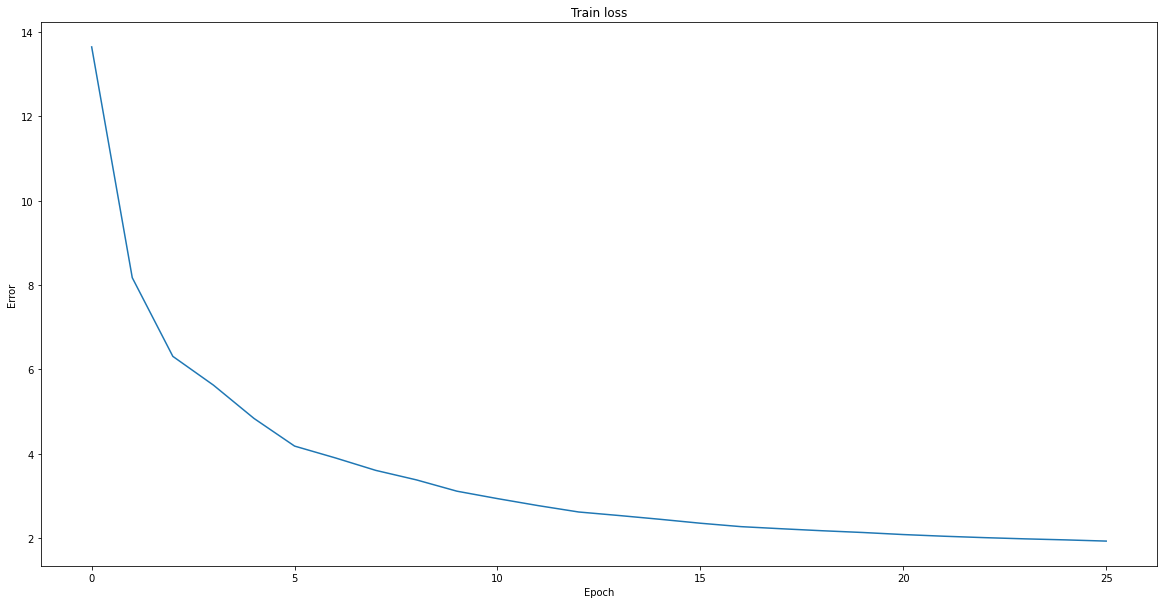

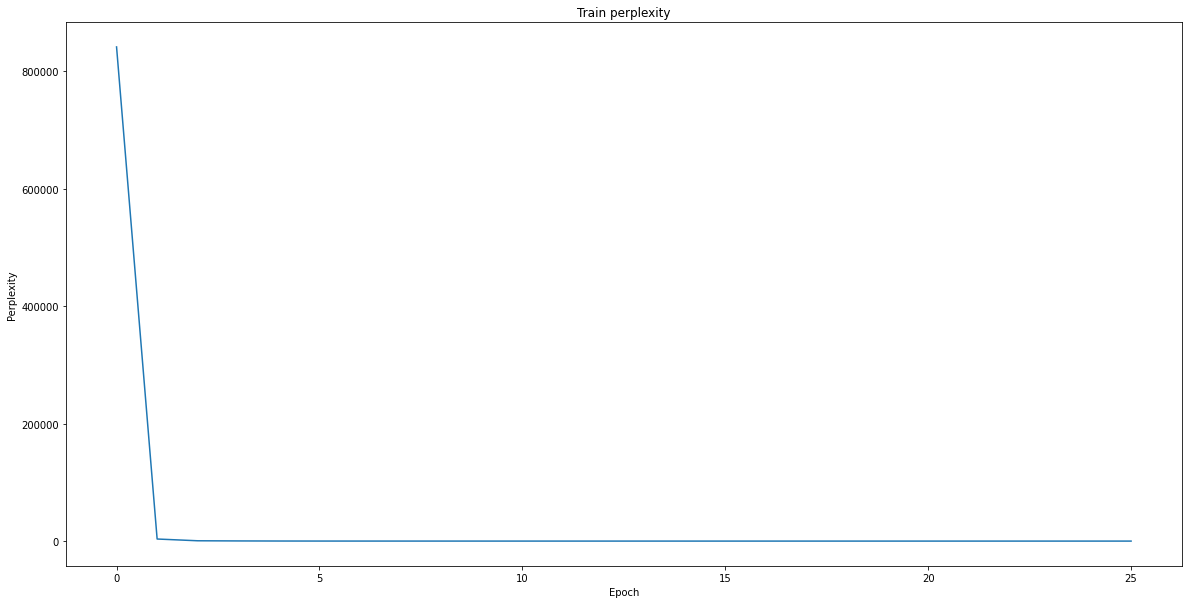

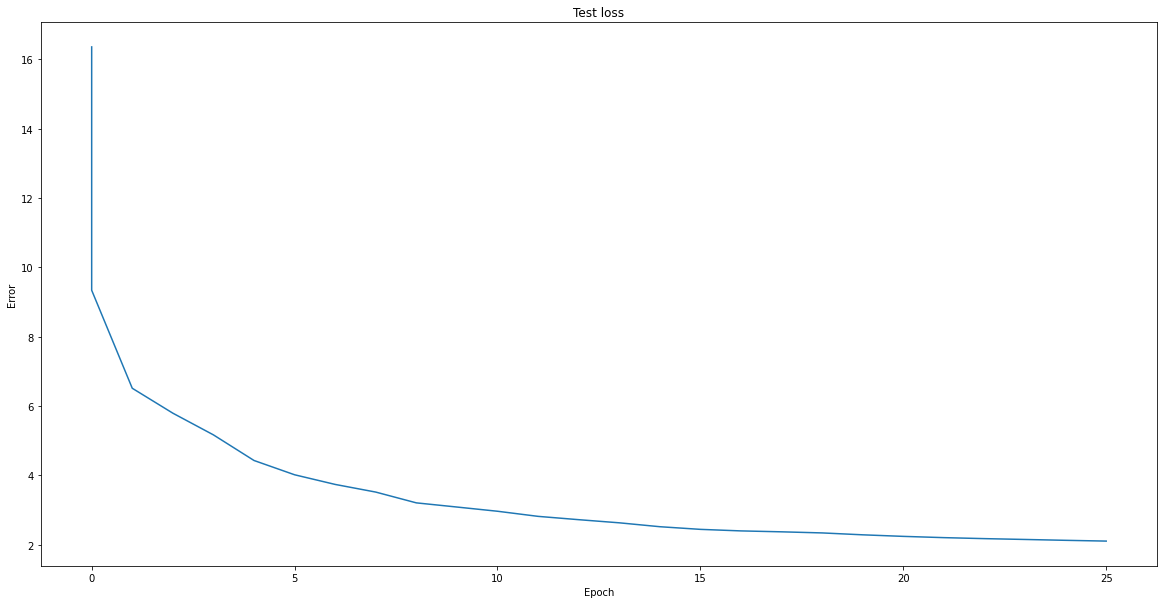

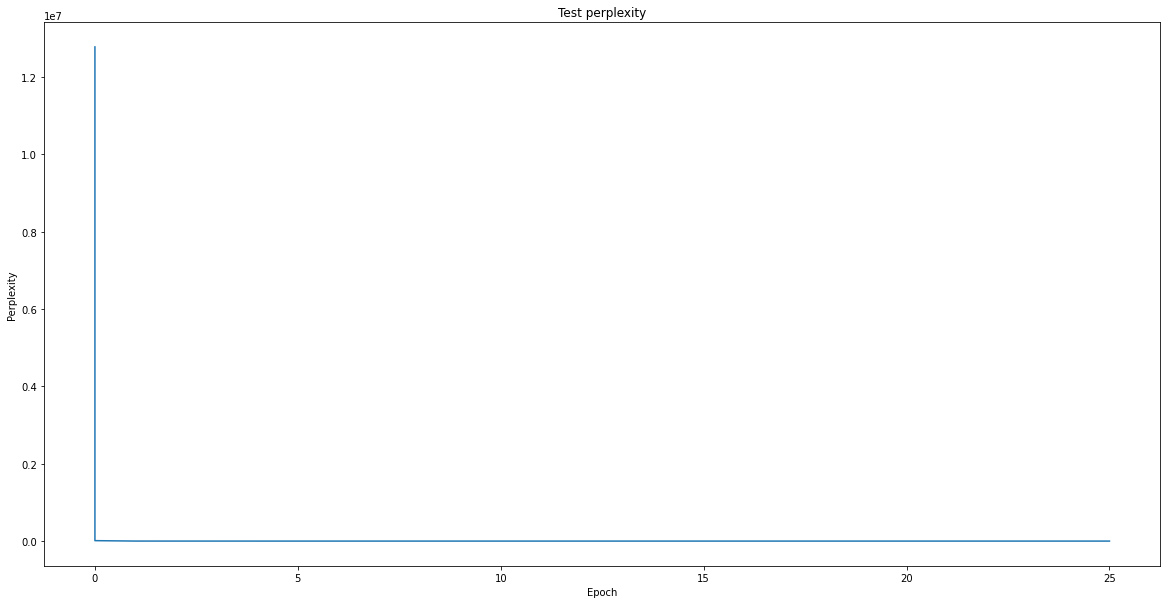

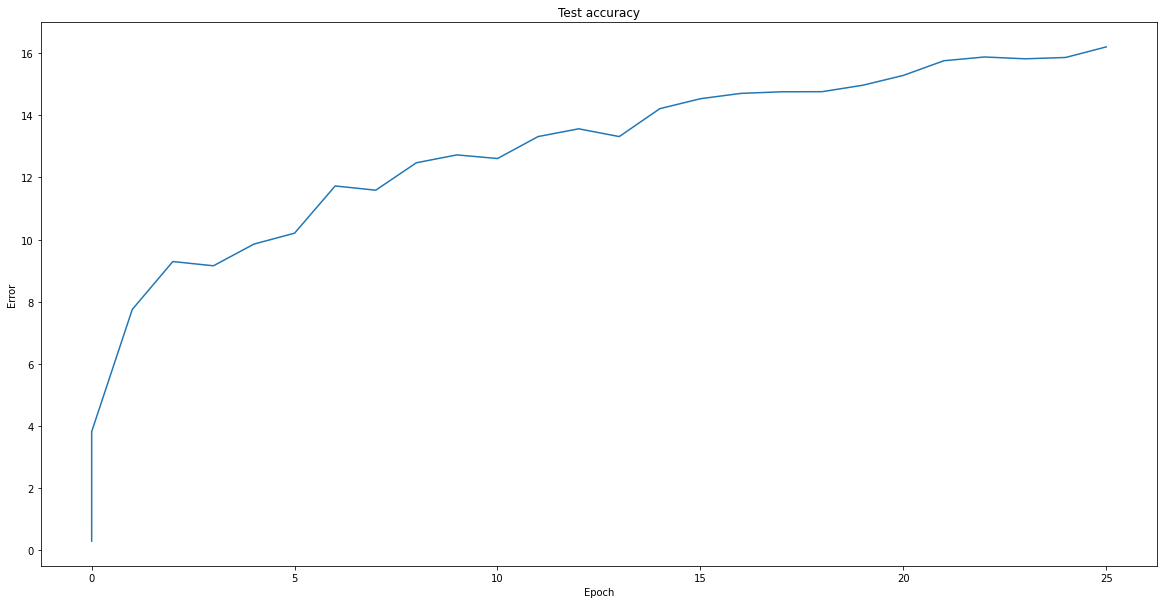

Final test accuracy: 16.203125
Final test perplexity: 8.186450516294695


In [27]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 25
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/beemovie/' + VERSION + '/'

    data_train = HarryPotterDataset(DATA_PATH + 'beemovie_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'beemovie_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'According to all known laws of aviation, '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

In [28]:
def eval_final_model(model, vocab, device):
    seed_words = 'Yellow, black '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Yellow, black to the bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee b
generated with sample	 Yellow, black to we don't be it the the worke I the bee humans and for the make are eat it wim me the a well, but of thes met han the and to the bees have he bee wille ave to bee bardy shoney aLdion thes heres. It'
generated with sample	 Yellow, black to the abuttedo care funchoney diden't bee we don't pad to me and the some here the are son life. There in there non the beenson are have to you a lust abe to that a stalking to be could. - I sust anc
generated with sample	 Yellow, black to this will sturnce in fill he diden't a bee for prout the been fellow...... - I sont working to what rad wanto the are and to the reare! Honn alow. What a stright? We's a bees! Spentso the have nony
generated with sample	 Yellow, black out the wo my 

## 8.3 LSTM Bee Movie

In [38]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True) # GRU -> LSTM
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state) # GRU -> LSTM
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([71, 512]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.weight_hh_l0 -> 	torch.Size([2048, 512]) = 4MB
lstm.bias_ih_l0 -> 	torch.Size([2048]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2048]) = 0MB
decoder.weight -> 	torch.Size([71, 512]) = 0MB
decoder.bias -> 	torch.Size([71]) = 0MB

Restored all variables
No new variables
Restored /content/logs/beemovie/0.1/032.pt
Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 aea   Wea   -te tnenesl   tin W'toee'



Test set: Average loss: 2.3545, Accuracy: 3524/25600 (14%)



100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

Train Epoch: 32 [0/512 (0%)]	Loss: 2.315263


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	eoeese -uese -ooskseckk    bae - cos o



Test set: Average loss: 2.9373, Accuracy: 3217/25600 (13%)

Saved /content/logs/beemovie/0.1/032.pt

generated max		 According to all known laws of aviation, beesees! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Therese! Th
generated sample	 According to all known laws of aviation, I col ood o cor oo cor cor ood cor mor oo cor com or oo cor po boo do beese! cor cor oo col ood om ood or cor cor oo do caretis, or cor or a verecrese! - o yo colow so cold oo cor cor do cor dor ood c
generated sample	 According to all known laws of aviation, you go comes! They'ere! Hoow ood ow ood oo cor comese! To kingo col oo do ood cor omese! - I come! They? - o cor om col o cold o Hoow herese! They or corom or ood us ood carre, coor dow ow

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

Train Epoch: 33 [0/512 (0%)]	Loss: 2.889839


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 te    Te    Yte tneneteo  ta  Tttote'



Test set: Average loss: 2.7121, Accuracy: 3341/25600 (13%)

Saved /content/logs/beemovie/0.1/033.pt

generated max		 According to all known laws of aviation, that tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat tat
generated sample	 According to all known laws of aviation, you're ttan tat ttin ttat ttat tat te ttle ttin to tat tile tane tat tt tat tan tan tat tit tat tat tat tat tat tan tat tin tan tating that tut tut tan tan tat tat tat tit tios it ttan tat tattile nou
generated sample	 According to all known laws of aviation, stin tatin ttile tht tat tatting tattin ttile ttan tat tan tattting ttin ttan ttile ttin ttat tat that tat ttaking ttle tin tan tat ttatting ttat tat tat tat tat tat tat to tat tan ttat ta

100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

Train Epoch: 34 [0/512 (0%)]	Loss: 2.656233


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	theen  Yeant Yterinenesly? byn Y'sone'



Test set: Average loss: 2.4374, Accuracy: 3208/25600 (13%)

generated max		 According to all known laws of aviation, stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a stery, been a ster
generated sample	 According to all known laws of aviation, - shoperstearsinnaybourry. Sourry. Yourring a loffery, What's veren for, beastin? Yourly, beento seamen istoorry. Stose intosen't forry, in aind fay amaybourring flofery, shourry......................
generated sample	 According to all known laws of aviation, got. Yead fay? I'm a hourstinking tof fffforry. Yourrin for! What forry, a stoodersting a forry. Oh, yourry, shoure a ffrorry. - Whave a feay? fachumab.................................................
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

Train Epoch: 35 [0/512 (0%)]	Loss: 2.386089


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 weed. Weed. -eeailecesl   bya I dose'



Test set: Average loss: 2.2713, Accuracy: 3676/25600 (14%)

Saved /content/logs/beemovie/0.1/035.pt

generated max		 According to all known laws of aviation, what wo don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't don't 
generated sample	 According to all known laws of aviation, wheary wass is not I now don't where don't so what wo know don't don't don't eass don't hearry. What wo ldreary. I don't mon of why my reary son don't mear. I dis whis he's don't know died a will will
generated sample	 According to all known laws of aviation, I don't on was dis wheart is don't o did working on there don't don't don't don't wo mears. I don't don't meads. Moseved is don't beey will don't men I don't ney was don't a beed a don't r

100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

Train Epoch: 36 [0/512 (0%)]	Loss: 2.197302


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 wees. -ees. -oeekl cell   te. I wod '



Test set: Average loss: 2.2789, Accuracy: 3718/25600 (15%)

Saved /content/logs/beemovie/0.1/036.pt

generated max		 According to all known laws of aviation, this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo this wo 
generated sample	 According to all known laws of aviation, wanto this go thim this wo the this wit thim thing! I don't mon the wo want. I want o thinghing thim. - I cances this will this ithis wo thimp.. - I wo this the wir. I don't this are this what I wanto
generated sample	 According to all known laws of aviation, wall wit this warr this want the this me this wit I don't o this wo don the is well on this wir this wo this ware don't a liking. I know long the on the wo the is is what wo this, withing 

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Train Epoch: 37 [0/512 (0%)]	Loss: 2.199294


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 aees! -aes, -oeeknenell   ta. - con '



Test set: Average loss: 2.1885, Accuracy: 3819/25600 (15%)

Saved /content/logs/beemovie/0.1/037.pt

generated max		 According to all known laws of aviation, an the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care the care
generated sample	 According to all known laws of aviation, some the to ould the cane. I cand the iting all the care to all care that the it. The are to bees. The wanto alan the cardy, I cante the thate. This it. This an a call thing, bees are to alk aneciall 
generated sample	 According to all known laws of aviation, our to card to care one. Hees and call the it. Thate dot. - I cand the to the the cree to sare ould the care the stare the the ardes! The cesust. This the care thating. Hel. - I call call 

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

Train Epoch: 38 [0/512 (0%)]	Loss: 2.112992


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 cee   Tues  -uerknenell   ba  T cone'



Test set: Average loss: 2.1167, Accuracy: 3917/25600 (15%)

Saved /content/logs/beemovie/0.1/038.pt

generated max		 According to all known laws of aviation, bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, I cand right it that sme of the you're can a have bee bee could your you I'm now your your lits it a can the come liting bee bee. - That eare of meve in ofee bee bee could yould of your sting a the yo
generated sample	 According to all known laws of aviation, I can a could it. - I custand a lowe hey in meve of ithe your now of to of a right ive there there suhere your it nowe ard. And you're yould your sun here your sting ittalking it a can you

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

Train Epoch: 39 [0/512 (0%)]	Loss: 2.043362


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 hee   Tues  -oertsenell   ban T dose'



Test set: Average loss: 2.0872, Accuracy: 4042/25600 (16%)

Saved /content/logs/beemovie/0.1/039.pt

generated max		 According to all known laws of aviation, bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, sones of they sille bee! You lood got this what your have the here fin a don't he so honey, honey now here bee stris hove don't noow hout have be your honey have of honey bee ther hey dowet have this 
generated sample	 According to all known laws of aviation, flen hour nout honey our your hen bee bees beed of the bee bees of the is hure your good. And my in the hones! We're loold goots fache in that you're your hure hat your hour ines honey see

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

Train Epoch: 40 [0/512 (0%)]	Loss: 2.005364


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   Yeen  Yoeateenesl   ban Y dode'



Test set: Average loss: 2.0559, Accuracy: 4003/25600 (16%)

generated max		 According to all known laws of aviation, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
generated sample	 According to all known laws of aviation, don't the strads to there then't a like that there honey deast a a lost. I don't a wastaing the the bee like bout the sme to the to fies the honey that? may fllows that to the a this it hout hey stain
generated sample	 According to all known laws of aviation, not the gottating threat int? - We'll the to that? I don't tand to the have a flowere the hout think ming that weatting thenly weah, honey be the a sone! You the was humansonstir, lot the mand to then
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

Train Epoch: 41 [0/512 (0%)]	Loss: 1.964676


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 aee   -ees  -eerteenell   wy  - dod '



Test set: Average loss: 2.0379, Accuracy: 4010/25600 (16%)

generated max		 According to all known laws of aviation, the was a some the was a some the was a some the was a some the was a some the was a some the was a some the was a some the was a some the was a some the was a some the was a some the was a some the w
generated sample	 According to all known laws of aviation, you get hereat wo be the Honed to a cour some bragow do the we my way I don't do was deare fare a a hones areamme mon a fing to be and was the was any wout the was get a a lifes it the aree the have t
generated sample	 According to all known laws of aviation, was ase are the we hat's to low don't the mot the a some arry way for a whot there intere man't was hour Non the the was ound a my a malking intty where thing. Seas an to was in to be a ling the with 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

Train Epoch: 42 [0/512 (0%)]	Loss: 1.934877


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee . Iees. -oerieenell   Iy  I dode'



Test set: Average loss: 2.0191, Accuracy: 4145/25600 (16%)

Saved /content/logs/beemovie/0.1/042.pt

generated max		 According to all known laws of aviation, I don't the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the some the
generated sample	 According to all known laws of aviation, I don't the the mere. - I gut of the some an smor the so there the the die thing it the she in to sture are an an the are this is it there on of this a she the you so plarry. I do were the are the som
generated sample	 According to all known laws of aviation, our it the a this I don't bee do in could here some thing the somer? - Here the is is the will stice stur forry. - I can't tho an It's poing to the some on the sarry. I sante sion there it

100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

Train Epoch: 43 [0/512 (0%)]	Loss: 1.905817


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oerioenell   by  - cose'



Test set: Average loss: 1.9909, Accuracy: 4162/25600 (16%)

Saved /content/logs/beemovie/0.1/043.pt

generated max		 According to all known laws of aviation, the come the the come the the come the the come the the come the the come the the come the the come the the come the the come the the come the the come the the come the the come the the come the the c
generated sample	 According to all known laws of aviation, what the bee they the stiring of bood. - Hon the cally what the cand your of comperet of the cand of this is that doney? What the have thing to a bees! They have the the stion a come thing to bee bees
generated sample	 According to all known laws of aviation, hare there there of the have that yournd thing bees of that the live the come the wore that and are comet the bee of your the me ned a come looding theres. What all of the bee could of the

100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

Train Epoch: 44 [0/512 (0%)]	Loss: 1.879121


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 aee   Tees  -eerinenell   ban T cose'



Test set: Average loss: 1.9749, Accuracy: 4218/25600 (16%)

Saved /content/logs/beemovie/0.1/044.pt

generated max		 According to all known laws of aviation, bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, a come hat you ging a could to a cand the you of the seed have on your of for is that you a could yout to we and a you cand a but your one. Dand my in a no weat a bee not a coust a a do the was heat s
generated sample	 According to all known laws of aviation, cand a of he could a humand and your ree louldn't ron they ward a crome a a a cand with wand the creed on't the bee bee that it bee bee it the supen a liting that is the with a could offfe

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Train Epoch: 45 [0/512 (0%)]	Loss: 1.863306


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   Tees  -eeriaenell   ban T cose'



Test set: Average loss: 1.9573, Accuracy: 4247/25600 (17%)

Saved /content/logs/beemovie/0.1/045.pt

generated max		 According to all known laws of aviation, but the bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, Gor crading to honey in for there dide funy for in to grack a sure head in a lit is gothe bee bee ithis bee! The you got goon a gon a read my is it is your nour there jus he you like in was mught work
generated sample	 According to all known laws of aviation, ming a stick our that with we a hiving to you got it it sand the bee on in the win the supen to man a you well think is is there not a din a ith with is a could here to be But you gottalki

100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

Train Epoch: 46 [0/512 (0%)]	Loss: 1.840404


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   Iees  -eeriaeeell   sya I tode'



Test set: Average loss: 1.9403, Accuracy: 4326/25600 (17%)

Saved /content/logs/beemovie/0.1/046.pt

generated max		 According to all known laws of aviation, some the the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee
generated sample	 According to all known laws of aviation, suple not a that of that it the on to make think in a smake the there think there there there the work we he can't the it will think the oney our hones are's it lit the gon thinke that sure honey were
generated sample	 According to all known laws of aviation, thes of the beens there this work the we're starour flawe hourld to the there dide was how do that's goth is is are stion sho got do felour somen that the are but is want the work the wo f

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Train Epoch: 47 [0/512 (0%)]	Loss: 1.818133


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaenell   sea I dode'



Test set: Average loss: 1.9280, Accuracy: 4359/25600 (17%)

Saved /content/logs/beemovie/0.1/047.pt

generated max		 According to all known laws of aviation, some the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the we have the
generated sample	 According to all known laws of aviation, and of you dot it were you don't the don't here the beard you have you don't a We're and way sidensoney, could flower you chour is is you'll like have the my seare of in the heare that? - It's stared 
generated sample	 According to all known laws of aviation, don't the we it were the bees to what sing out on the and mean and the lifee some the a weall king bee hout see honey bet it a bee the you that right work an have to mon a ally the don't w

100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

Train Epoch: 48 [0/512 (0%)]	Loss: 1.802595


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 aee   -ees  -ee iaenell   by  - dode'



Test set: Average loss: 1.9207, Accuracy: 4312/25600 (17%)

generated max		 According to all known laws of aviation, bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, weall the bees a gettere you're loney string the we a a call of hey work the on a bee a mons. - What was a little bees is it that the what the hand a stime. - It's a ste a the have do thing it a was a
generated sample	 According to all known laws of aviation, bee at a little bee litget it weat was me? - I know don't mear now don't to be have are this is thes an aslay! Than't would the bee we costiris an you day some that a make hat want the with have weate
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

Train Epoch: 49 [0/512 (0%)]	Loss: 1.788875


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaeeel    bya - cose'



Test set: Average loss: 1.9129, Accuracy: 4346/25600 (17%)

generated max		 According to all known laws of aviation, bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee the bee bee bee 
generated sample	 According to all known laws of aviation, a so honey eare far you hur strip of there stric to but you the what's a comentere. This wit of that was there don't of the specialould to bee sit to the bee a sting to the bee his a cand to the bees.
generated sample	 According to all known laws of aviation, ally is the the there in the cours is the was hat's a cand here hink it they bees a but of the his wars ther fin the bees! You don't strick. Buzz, bes. - I'm low.. That's a bout a flowers the preling 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

Train Epoch: 50 [0/512 (0%)]	Loss: 1.776265


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee ! Tees  -eeriaenell   baa T cone'



Test set: Average loss: 1.8994, Accuracy: 4351/25600 (17%)

generated max		 According to all known laws of aviation, bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee bee 
generated sample	 According to all known laws of aviation, prows somer it's have sting the bee bee bee to memaning the to some think heand a want to bee go the bee comen the could you where have in a good. May shole? - Were the the bees! - out the in a bees a
generated sample	 According to all known laws of aviation, Orand the is wast of the bee! - Helly bees! Ho was hat for the life. Where winthing to this think in the bee have going to sthink the and a you goned to thinking hat the make the ought bee beeling the
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Train Epoch: 51 [0/512 (0%)]	Loss: 1.763081


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeell   baa I code'



Test set: Average loss: 1.8914, Accuracy: 4403/25600 (17%)

Saved /content/logs/beemovie/0.1/051.pt

generated max		 According to all known laws of aviation, I can't a like the we have the bee bee bee bee the bee bee bee bee the bee bee bee bee the bee bee bee bee the bee bee bee bee the bee bee bee bee the bee bee bee bee the bee bee bee bee the bee bee b
generated sample	 According to all known laws of aviation, some. - I the are the come. There hat to for the beed to gonly see. They's a got a beess it the ree bees are the bee ins a comer this the read flowers, where you got it a was how my ney, have the hink
generated sample	 According to all known laws of aviation, I'm got it a little. All right the he doing the is the was for the read to the swe honey the the stard. You what the is the bee with that a was a could bee to the gottalking the here thope

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

Train Epoch: 52 [0/512 (0%)]	Loss: 1.748443


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeell   sya - dode'



Test set: Average loss: 1.8895, Accuracy: 4471/25600 (17%)

Saved /content/logs/beemovie/0.1/052.pt

generated max		 According to all known laws of aviation, I don't the bee the with is the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with the with t
generated sample	 According to all known laws of aviation, any the got it the my out of the breat ight. And to the bee! They in is a soy prout your lit. - What was have bee stand I don't the with you know wholl the are hoese that the care that fromme this not
generated sample	 According to all known laws of aviation, on a be to methere the that the s imake diding to this king it was a beess and the wittle the tar we the we have the bees. That was a pare the with is in the care fre that hear with have t

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

Train Epoch: 53 [0/512 (0%)]	Loss: 1.736498


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaenel    sya I dode'



Test set: Average loss: 1.8820, Accuracy: 4467/25600 (17%)

generated max		 According to all known laws of aviation, I don't the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee 
generated sample	 According to all known laws of aviation, the we pe could for the some that the bee sting a last they the with thing bee bees! That's gues got the the we're the heare in the stirring in the bees and I lover the bees! - Oh, have nor prit a lit
generated sample	 According to all known laws of aviation, you cournst of that a bees an that staring in a las a stirr, sore don't here. Mase a have you don't a stan a like bee a bee! Fire the bee the bee good! I'm going tripe a supe work it wo all right the 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

Train Epoch: 54 [0/512 (0%)]	Loss: 1.725876


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaeeell   by  I dode'



Test set: Average loss: 1.8710, Accuracy: 4482/25600 (18%)

Saved /content/logs/beemovie/0.1/054.pt

generated max		 According to all known laws of aviation, bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the 
generated sample	 According to all known laws of aviation, I don't the bee just a bee the have the gottalk the we flor in the bare more it of he we here talking thing bee his a bee a mellow. URReking on a life. It know what it the bee bee for the a could bee 
generated sample	 According to all known laws of aviation, not a bast of this is thing to bee this is the bee the the bee hive bees! I've don't bee thing this his will the bee stirrefully sturngere on the say there they gra life. - It's for the th

100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

Train Epoch: 55 [0/512 (0%)]	Loss: 1.713304


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeel    bya I code'



Test set: Average loss: 1.8649, Accuracy: 4488/25600 (18%)

Saved /content/logs/beemovie/0.1/055.pt

generated max		 According to all known laws of aviation, bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the 
generated sample	 According to all known laws of aviation, bee have you get a bee you care the bee case to there honey a sund teme oon a make it a pare for not the bee bee! You do you we have a like there not there you goney in thing cours? - I have some the 
generated sample	 According to all known laws of aviation, don't be bees sup of the need to me out of we put in the come the to that a case the supenson. You have day seent of to hive for you to the and to the read. And to bee so the sime. Bee don

100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

Train Epoch: 56 [0/512 (0%)]	Loss: 1.702460


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeel    sya I dode'



Test set: Average loss: 1.8611, Accuracy: 4512/25600 (18%)

Saved /content/logs/beemovie/0.1/056.pt

generated max		 According to all known laws of aviation, but the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the 
generated sample	 According to all known laws of aviation, in a some of it in a life human and offer. - I couldn't we the now pround to much the work one the it what it was thes dis you can as and to me that of the got on a bee in a all right is the come. - I
generated sample	 According to all known laws of aviation, sing to bee good it of diden't know. Thereading? - Nob gottalk the creare of that as could me of the care that a littleme bee! This ming the it what a bee a life. - I can't stan the paron 

100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

Train Epoch: 57 [0/512 (0%)]	Loss: 1.692176


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeel    Iya I dode'



Test set: Average loss: 1.8590, Accuracy: 4550/25600 (18%)

Saved /content/logs/beemovie/0.1/057.pt

generated max		 According to all known laws of aviation, I can't the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee 
generated sample	 According to all known laws of aviation, flowerse this the is the are all the have could I can't the bees any have nothis is to a was a bees! There fun the was hould to mean the a lifee. - It's don't stake it meall to sta bee to got bee a bo
generated sample	 According to all known laws of aviation, say bees are and to ha part to the what the with the reall pick astion, the cooming a something to you get of helly get were what the reall you do we have got a could of the heren asting b

100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

Train Epoch: 58 [0/512 (0%)]	Loss: 1.682538


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeel    ty  I dode'



Test set: Average loss: 1.8543, Accuracy: 4520/25600 (18%)

generated max		 According to all known laws of aviation, but the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the 
generated sample	 According to all known laws of aviation, honey bees to do be about. That's a bees, bees lifee. - I would hinking to meall have to the creating to some could we don't know what was move on think the parde on the sting the but of the bee here 
generated sample	 According to all known laws of aviation, have to stery. And that at state the but I don't de with is to strace of the bee! They're wead to membe the got some little them soment on there the it it for the here all you know. I don't don't know
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

Train Epoch: 59 [0/512 (0%)]	Loss: 1.671966


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -eeriaeeel    ty  I dode'



Test set: Average loss: 1.8481, Accuracy: 4564/25600 (18%)

Saved /content/logs/beemovie/0.1/059.pt

generated max		 According to all known laws of aviation, but the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the 
generated sample	 According to all known laws of aviation, but ear your hat a back a could he reed to some on the human derset talking to be sting to it. They're got me. You could bee have to den of there nee with mose of you have gint was have the with is th
generated sample	 According to all known laws of aviation, quite are to move! They! - Hell, stalking to gottal you cand to the could to good to we not of don't read and the freen to boy. OK, flowers the have are to speart it the bees! You don't he

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

Train Epoch: 60 [0/512 (0%)]	Loss: 1.661875


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaeeel    ty  I code'



Test set: Average loss: 1.8422, Accuracy: 4564/25600 (18%)

generated max		 According to all known laws of aviation, but the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the bee the 
generated sample	 According to all known laws of aviation, a little bees fund the this the goto bee the nece have think the reat down! I can't on a mantes. But work heard for we don't do we have to bee suman and are there thim. You have to stery the all on th
generated sample	 According to all known laws of aviation, a bee by in and the rease. That's a bout hat that a bee bees a little but you our he could of a could of the ever this will on the bee are of there the cance to for the some that here's the would Mayb
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

Train Epoch: 61 [0/512 (0%)]	Loss: 1.652175


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaeeel    Iy  I dode'



Test set: Average loss: 1.8378, Accuracy: 4580/25600 (18%)

Saved /content/logs/beemovie/0.1/061.pt

generated max		 According to all known laws of aviation, but the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the bee are the 
generated sample	 According to all known laws of aviation, Barry have work the bees a go. - Look are oney couple of the to see bread. - And the have to logur little smake it in what the gottalking to the bees meant meake ever the are you can a have in an life
generated sample	 According to all known laws of aviation, Just of the think you have not this is it will of the compan and hot you supend to the some be dididen! From of the ware thang to starting the me. I them of the with nothe oney in a little

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Train Epoch: 62 [0/512 (0%)]	Loss: 1.643046


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaeeel    ty  I dode'



Test set: Average loss: 1.8362, Accuracy: 4573/25600 (18%)

generated max		 According to all known laws of aviation, but the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little be
generated sample	 According to all known laws of aviation, gradess about to the nectery see. - Hey, all the bee say! Fought workaing on on the bee humans the cand the Hey have to the with the hey're the reating et they way don't know I don't know what the bal
generated sample	 According to all known laws of aviation, belie the bee. That's a bee to get a his it was a humans what bee a could bee gon in the can a from the we don't stan the have to bee a paite, and to the some here one? - I want ben a little to go the
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

Train Epoch: 63 [0/512 (0%)]	Loss: 1.633841


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy  I dodn'



Test set: Average loss: 1.8329, Accuracy: 4577/25600 (18%)

generated max		 According to all known laws of aviation, but the bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a little bee the bees a l
generated sample	 According to all known laws of aviation, you gone. That is the care you get our have the heard teme of the was a have to this was the bee days the say for what to the be ar movised. The How do make was lowers. This is is the the what was the
generated sample	 According to all known laws of aviation, Buzz, buzz, but got a me. I'm gottalk we don't you got to stick are to the with make on the some all we could. - It's a bee for theme. I case the stick honey the have bees all sting, they wany the ust
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

Train Epoch: 64 [0/512 (0%)]	Loss: 1.624482


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy  I dodn'



Test set: Average loss: 1.8278, Accuracy: 4586/25600 (18%)

Saved /content/logs/beemovie/0.1/064.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, and have thing a sheir don't know what it me. Hey, you little bee flower. - I don't a some the here can't starting to humans and you're you want of the bees are to you all you get a little the bees ca
generated sample	 According to all known laws of aviation, stirry, what a bee! They're not on a bee cand the his are talking to was a may his is the poplen the reess have to stalking to the stirr! Where world prose to bee. I can't the seem one in 

100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

Train Epoch: 65 [0/512 (0%)]	Loss: 1.615400


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy  I dodn'



Test set: Average loss: 1.8251, Accuracy: 4614/25600 (18%)

Saved /content/logs/beemovie/0.1/065.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, here hour sting to sting to like to have the we care the could you get it a cout of the are you don't do the couffe. I don't here all that the stirs, and a little sure. - And the sup for not on the ro
generated sample	 According to all known laws of aviation, but the ming bee the say that work the got a stirre of the couldn't bee got a making the work I came bees come the bees! They in this is the work have thing to the sun think the sees they 

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

Train Epoch: 66 [0/512 (0%)]	Loss: 1.606541


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -oeriaeeel    Iy  I dodn'



Test set: Average loss: 1.8222, Accuracy: 4628/25600 (18%)

Saved /content/logs/beemovie/0.1/066.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, a ball this a sit of them! Honey to lettle bees. - You're you can to be and to this houre have to sme. Bee the bees! What the don't a say, the have to do with on this is is the reant is the bood. You 
generated sample	 According to all known laws of aviation, the of the his what a mice. - I call a sticks this even the see here will right, with more the bees! That is the say! I menter for the peard as me on of the with the bees. Bees for you got

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

Train Epoch: 67 [0/512 (0%)]	Loss: 1.597213


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -herieeeel    Iy  I dodn'



Test set: Average loss: 1.8195, Accuracy: 4624/25600 (18%)

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, with your are your we have on the bee in the some this this is is the some on the bees the a bee to the hive got of the have noch a could bee have bee the could a bee can't bees are the the she pre yo
generated sample	 According to all known laws of aviation, you can a some this is flow what the have to the could sup can't you got a coodle cause here. You have got mean as the have to you all we have to the bees! Oome don't know, I can't a live to do the be
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Train Epoch: 68 [0/512 (0%)]	Loss: 1.588046


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy  I dodn'



Test set: Average loss: 1.8166, Accuracy: 4651/25600 (18%)

Saved /content/logs/beemovie/0.1/068.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, and have to honey and aw sting to the bee bees! This is with a shourt is think the is course the have talking the pare for the humans! All righto this is cread to here? Bees have to this the honey! I'
generated sample	 According to all known laws of aviation, we have the bees! Oh, thes was mon this is honey was timation the bees! They doing the sure they doing to be bees are you get to bee have not thing someting to stare don't know. I can't a 

100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

Train Epoch: 69 [0/512 (0%)]	Loss: 1.579249


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8145, Accuracy: 4655/25600 (18%)

Saved /content/logs/beemovie/0.1/069.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, flowers. Bee are life. I sheck and I coulder stanting to bee with is of the bees a life. And it in of the ready for that is that hat? We're that the here all a be a flowers what you can't do it do the
generated sample	 According to all known laws of aviation, proods. We have to up. You know what a rumbe bee of hoing. - I don't know, but the care you in the bees! - The bees! - Honey a was a little stalking the have to do course thing work they a

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

Train Epoch: 70 [0/512 (0%)]	Loss: 1.570172


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8132, Accuracy: 4671/25600 (18%)

Saved /content/logs/beemovie/0.1/070.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, Oh, Bees are you don't know what that the comother what do the can't bee some the bees! Oh, my special stick our honey stare can't that the are some human for coming. Deadiffice. - Shumans with they w
generated sample	 According to all known laws of aviation, for there there. - What it's on the bee the the comper. Mose the rearen to the have on the something the me. This is is the bee you can sone bees and to you long the cary provies fun the b

100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

Train Epoch: 71 [0/512 (0%)]	Loss: 1.561334


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -herieeeel    Iy. I dodn'



Test set: Average loss: 1.8112, Accuracy: 4673/25600 (18%)

Saved /content/logs/beemovie/0.1/071.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, Sto your life. - Honey have a say to sta could be about our prose the here is you can a little stare the bees! What it. But it, sting to be a see job a could you don't meres the she you can you wearn 
generated sample	 According to all known laws of aviation, but the irls. So what way surs, your life. So that it thinkey been of the who lose casaide an the it was it on the have ris their was a painto smake that to a that the cright. I got a cour

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

Train Epoch: 72 [0/512 (0%)]	Loss: 1.552436


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -herieeeel    Iy. I dodn'



Test set: Average loss: 1.8092, Accuracy: 4693/25600 (18%)

Saved /content/logs/beemovie/0.1/072.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, just what the the bee is court the are you to was a bee have in thinking bee. - Beens and the on you can as are the could you cousing the read. That's this what the job the this who you that.... Bees 
generated sample	 According to all known laws of aviation, for that is the here. I could here the jars, but the got a bee a little but your life. I don'te know the the hive to on bee do the what the bee have think it is whorre reading the make it 

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

Train Epoch: 73 [0/512 (0%)]	Loss: 1.543594


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -herieeeel    Iy. I dodn'



Test set: Average loss: 1.8069, Accuracy: 4704/25600 (18%)

Saved /content/logs/beemovie/0.1/073.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, it's the would be the bee bees! Thinking ho cause to stering to thing Mr. Bee in the do stear the the sting to be a bees and of theme bees! This is this compater. Most a lose. I scan't do your sting b
generated sample	 According to all known laws of aviation, so be to a comp. Well, yellow, but the bee. - I'm gonna for the is ever the bees the got a bee this will right you want the sto do there that it make it is the is and of your life. I have 

100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

Train Epoch: 74 [0/512 (0%)]	Loss: 1.534410


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -herieeeel    Iy. I dodn'



Test set: Average loss: 1.8064, Accuracy: 4713/25600 (18%)

Saved /content/logs/beemovie/0.1/074.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, course what the sticks of there to the bees! Oour lease you don't bee funny. I gonna sting the strickes! Sporting it the we can't really matter. Mayb about the bees! Oh, you can there. I take to jare 
generated sample	 According to all known laws of aviation, here. I can't the reating. What ase this is the have to a latter it a lust distenting in tho my life! The bees! Why don't know, have to do it. Oan't striped for our night for the stalking 

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

Train Epoch: 75 [0/512 (0%)]	Loss: 1.525722


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8053, Accuracy: 4705/25600 (18%)

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, but the with me too king the every stalking to a have to see think they could bee bees poing the bees a could you to start the greate think it. Oan shourting. And the good compan the course don't new 
generated sample	 According to all known laws of aviation, my sury, I'm a gotta going to statick of you here that the world you get to bees! That's a dide can't bees are you can and off the will humans you getat in the bees! This is the work the have to the s
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

Train Epoch: 76 [0/512 (0%)]	Loss: 1.516852


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8041, Accuracy: 4712/25600 (18%)

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, what do the smoke. So read. I the bees! They can just what bee. You have job the the stick our for that talking to have to me honey can and to stears. Hellow, but your have to stuff. It's gonna thing.
generated sample	 According to all known laws of aviation, but out hat was the bees! The poick a coming. - I was a little bees and to a honey facture, have to meall face. It's mean twas a little a bee dies. And you get string to be a little guy. I sup and to 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

Train Epoch: 77 [0/512 (0%)]	Loss: 1.507762


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8036, Accuracy: 4729/25600 (18%)

Saved /content/logs/beemovie/0.1/077.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, please. All right. And the scarent. - I don't nectar comes! - Where bees! And the bees! Adam, and a have to go on there we the ready bee are you can that this the with man as a little a little the bee
generated sample	 According to all known laws of aviation, the do the could but you can a bee on you course to be for the bees out choney, sting to surning. It's to be got that was a humans all the make it make to me bee an a seents the see thinki

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

Train Epoch: 78 [0/512 (0%)]	Loss: 1.498760


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8032, Accuracy: 4735/25600 (18%)

Saved /content/logs/beemovie/0.1/078.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, clectory is that a little go. You a bee bee the bees! There's morest were we honey that at was a sup of you know what you don't know, I can't the here. I'm going this constirsed to a bee all this that
generated sample	 According to all known laws of aviation, cool. - We have to do no they work on the a honey? - Oheck hey down! I know what was a little with was mically scriped Moving to here is the besten. So honey is on a sture, you got a bee t

100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

Train Epoch: 79 [0/512 (0%)]	Loss: 1.489757


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I dodn'



Test set: Average loss: 1.8028, Accuracy: 4740/25600 (19%)

Saved /content/logs/beemovie/0.1/079.pt

generated max		 According to all known laws of aviation, but the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The be
generated sample	 According to all known laws of aviation, the some bee think bees! - You're blowers, sting to me little it our polling, my sorry. - What was you want to a bee the bees! They have there the bees! Hellower what I the bees! The is up. Oan this t
generated sample	 According to all known laws of aviation, the humans and the are your lease here you go it our not of them with a paseces of the bees! Bee hive, but thinking the hive. I can't know. I have to sucknow. - I the steard. Stand to sure

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

Train Epoch: 80 [0/512 (0%)]	Loss: 1.480756


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I codn'



Test set: Average loss: 1.8027, Accuracy: 4746/25600 (19%)

Saved /content/logs/beemovie/0.1/080.pt

generated max		 According to all known laws of aviation, but the work a humans and the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The 
generated sample	 According to all known laws of aviation, scriped out there the bees areful. I starder we can your thing. All right. - Byearning. - I don't all the hive don't not the will right. They're in the was a could be bee are bees a little guys! The b
generated sample	 According to all known laws of aviation, " will deaste! What it was make ot that. - Yeah, have good a was any the scaree days that thinking bee going the firmates. We something the work have on this with the team. Ooffee. You kno

100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

Train Epoch: 81 [0/512 (0%)]	Loss: 1.471680


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. I codn'



Test set: Average loss: 1.8028, Accuracy: 4759/25600 (19%)

Saved /content/logs/beemovie/0.1/081.pt

generated max		 According to all known laws of aviation, but the work a humans and the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The 
generated sample	 According to all known laws of aviation, stirring. It's a bee this from this is this is to here. - You side one have to you see the bees! We are you don't bees and the not of for this constirs? It's a bee have to a little bees! Are you don't
generated sample	 According to all known laws of aviation, you can and here we and the bees! That a part to go that. Look at was a was mach of the scared to be a boy a little boys! - Oh, my be a flowers that. All right. Bee you don't there is the 

100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

Train Epoch: 82 [0/512 (0%)]	Loss: 1.462528


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. - codn'



Test set: Average loss: 1.8034, Accuracy: 4780/25600 (19%)

Saved /content/logs/beemovie/0.1/082.pt

generated max		 According to all known laws of aviation, but the work a honey a could be are you don't know what the work a honey a could be are you don't know what the work a honey a could be are you don't know what the work a honey a could be are you don'
generated sample	 According to all known laws of aviation, it. I mean you can you consting to supporting. But the with know what hat if it is team. Bee out the say want to a be are thing bee! This is your honey get the bees! From the sten to get it on the sti
generated sample	 According to all known laws of aviation, stirrer! What was were we think have to the human. I the st. Mr. And life! You don't know what that the this eard a from it! Oome my life. I can't to good lone of this where sheck to be a 

100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

Train Epoch: 83 [0/512 (0%)]	Loss: 1.453321


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. - codn'



Test set: Average loss: 1.8042, Accuracy: 4789/25600 (19%)

Saved /content/logs/beemovie/0.1/083.pt

generated max		 According to all known laws of aviation, I can't bee the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees
generated sample	 According to all known laws of aviation, I start the we cometing the row do it up and ar seent? - I can't the hive. Oh, Barry, Bees on the bees! I have need to be and ant to so here. I don't know what pack out hat was a see? I got a sure, yo
generated sample	 According to all known laws of aviation, head make it what the cause the hive to be a little coming. - We're preand to be a humans life? I don't smoke. - I want the with no they are in a gintona get the the bees! - This will have

100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

Train Epoch: 84 [0/512 (0%)]	Loss: 1.444141


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  -heriaeeel    Iy. - codn'



Test set: Average loss: 1.8052, Accuracy: 4798/25600 (19%)

Saved /content/logs/beemovie/0.1/084.pt

generated max		 According to all known laws of aviation, I can't bee the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees
generated sample	 According to all known laws of aviation, powntered to bee don't know I'm going through work at the bees! And the world. I can't the that here. You all the bees cand the bees on the home in the takee the hive with a bee are you here starting 
generated sample	 According to all known laws of aviation, we have the the hotes! We're the was that it was a little bees! I don't know. How do you get in the reat the scared to be in Save to a care! - It's the see the matter was the don't the was

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

Train Epoch: 85 [0/512 (0%)]	Loss: 1.434852


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  Yheriaeeel    Iy. - codn'



Test set: Average loss: 1.8065, Accuracy: 4798/25600 (19%)

generated max		 According to all known laws of aviation, I can't bee the bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees! The bees
generated sample	 According to all known laws of aviation, How do that a could you see? This isn't bee bees! Mr. Mosting think a him one say stirrer! - What are you can a could be been a coming? The bees! Free the stick our honey what the work the could you l
generated sample	 According to all known laws of aviation, you some of the see where we have the sting the world and for this could it. One this is a reams. - It's fare to the much a happy think in there. This is the this any think. They bees! This is your wh
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

Train Epoch: 86 [0/512 (0%)]	Loss: 1.425532


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tee   -ees  Yheriaeeel    Iy! - codn'



Test set: Average loss: 1.8083, Accuracy: 4803/25600 (19%)

Saved /content/logs/beemovie/0.1/086.pt

generated max		 According to all known laws of aviation, I can't bee the hive to be a little guys! - I can't bee the hive to be a little guys! - I can't bee the hive to be a little guys! - I can't bee the hive to be a little guys! - I can't bee the hive to 
generated sample	 According to all known laws of aviation, Do you lot like a put it rand any the can a little girl that. Look at the hink is the hive gall the the honey whater about the will have to be are you to the bees! Free the joble of the here is this w
generated sample	 According to all known laws of aviation, in the hive. I could you get no this? - Oh, they eary work thome the bees! Free the some hive. Out I make thim. It's a bee a could put beer bees! Yeah, arry King this. It's not a bee can o

100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

Train Epoch: 87 [0/512 (0%)]	Loss: 1.416184


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  -ees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8105, Accuracy: 4807/25600 (19%)

Saved /content/logs/beemovie/0.1/087.pt

generated max		 According to all known laws of aviation, I can't bee the hive to be a little guys! - I was that the with man a could be are you don't know what the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but
generated sample	 According to all known laws of aviation, and as a bee you can your life the will have we have the bees! Free the mand asticks the work down! I'm sorry. - Yeah, I'm not a said a honey we have one joke hive is and a should he have that a bee a
generated sample	 According to all known laws of aviation, the can for the the every is the the we could it. Maybe this is a been of the win the move it on the en just in the care you go the make it out. I was move think you're nomer what your res

100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

Train Epoch: 88 [0/512 (0%)]	Loss: 1.407125


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  -ees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8135, Accuracy: 4809/25600 (19%)

Saved /content/logs/beemovie/0.1/088.pt

generated max		 According to all known laws of aviation, I can't bee the hive to be a little guys! - I was that the will have to be a little guys! - I was that the will have to be a little guys! - I was that the will have to be a little guys! - I was that t
generated sample	 According to all known laws of aviation, Mr. Mr. Montom! Bee Movie didence? - She's a bee are you don't know I'm reming. The bees! The the bees! Free the what the with mosquite with mach it in there. I don't know what you get strive to mean.
generated sample	 According to all known laws of aviation, bee. - Hellowers wind here three bees! I'm track it free the case. - And the hare was a lot the still we can aned of the world no the stick may bearding the ready never the humans here is 

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Train Epoch: 89 [0/512 (0%)]	Loss: 1.398353


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  -ees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8170, Accuracy: 4809/25600 (19%)

generated max		 According to all known laws of aviation, I can't bee the hive the bees! The hive with man a crazy stell of the bees! The hive with man a crazy stell of the bees! The hive with man a crazy stell of the bees! The hive with man a crazy stell of
generated sample	 According to all known laws of aviation, There's a little we come bee pereniever bees! Free the hive. I they here they will stry don't know your life. And who see honey is what fache. - I'm gotta stick an my sill we have no the croming it's 
generated sample	 According to all known laws of aviation, Barry. I'm going to do no me the mand acking the couldn't bee sare these in the hive to he humans and the bees! That's going the world because you can you couldn't be great the scare the sticks what h
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

Train Epoch: 90 [0/512 (0%)]	Loss: 1.389638


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8203, Accuracy: 4807/25600 (19%)

generated max		 According to all known laws of aviation, the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the 
generated sample	 According to all known laws of aviation, we've the bees! - Hey, don't leave the bees! Free the make it on the with the humans, where were the rese to go the bees! You know, I can't bee gotta gone the don't stry is the with man and been a las
generated sample	 According to all known laws of aviation, I can't bee don't know what hat was that is the they carefully. That's a bee have to the en every been laws happened to he could me. - What is the the bees! That's go. - Well, here's a little get is t
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

Train Epoch: 91 [0/512 (0%)]	Loss: 1.380490


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8227, Accuracy: 4810/25600 (19%)

Saved /content/logs/beemovie/0.1/091.pt

generated max		 According to all known laws of aviation, the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the hive, but the 
generated sample	 According to all known laws of aviation, you sirders? - Yeah, with they have good for the bees! I gottalk to companing of the bees! Free these from the bees! That's a bee are you can to a couple of the bees! Why doesn't have to see honey hav
generated sample	 According to all known laws of aviation, stapt the with in the hive was miness. No. Bee in here stends the hinkey every all the think is the evidence? - Yeah. - The mans! I know what I knew I have to go the bees! The see have to 

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

Train Epoch: 92 [0/512 (0%)]	Loss: 1.370107


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8248, Accuracy: 4818/25600 (19%)

Saved /content/logs/beemovie/0.1/092.pt

generated max		 According to all known laws of aviation, the hive, but the we could be a little guys! - I want to the stick our honey a could be a little guys! - I want to the stick our honey a could be a little guys! - I want to the stick our honey a could
generated sample	 According to all known laws of aviation, Barry, I'm really? To be are on this this the carder that. You know sorry. I'm a from NPR New in here. - Hey, not dead? The could be breattery's a bee don't know that bees. - What is the the just visu
generated sample	 According to all known laws of aviation, you're the bees! And it, be anything the every the never they everything a coming. But you want the not of the stell of dist. Yeah, I'm not all thing to here it up, bee are to like one thi

100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

Train Epoch: 93 [0/512 (0%)]	Loss: 1.358842


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees  Yheriaeeel    ty! - codn'



Test set: Average loss: 1.8276, Accuracy: 4819/25600 (19%)

Saved /content/logs/beemovie/0.1/093.pt

generated max		 According to all known laws of aviation, I can't bee don't know what the hive. I can't bee don't know what the hive. I can't bee don't know what the hive. I can't bee don't know what the hive. I can't bee don't know what the hive. I can't be
generated sample	 According to all known laws of aviation, Mr. Montlemen, Barry? A like to back the hive, but they're gotta sting to honey for your proud be to the runcorice. Sting an the hive want to do sing to the some of the bees! They does heard it in thi
generated sample	 According to all known laws of aviation, Barry. - Am put it is the was that? - Oh, my Bear fly in the some honey chan any the world attle bees and be a been a little cometing the what the humans. Bees is here. - Hey, you see wher

100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

Train Epoch: 94 [0/512 (0%)]	Loss: 1.347915


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees  Yoeriaeeel    ty! - codn'



Test set: Average loss: 1.8318, Accuracy: 4809/25600 (19%)

generated max		 According to all known laws of aviation, I can't bee don't know what the will here. I don't know what the will here. I don't know what the will here. I don't know what the will here. I don't know what the will here. I don't know what the wil
generated sample	 According to all known laws of aviation, I pready for the bees! Free the smoking bee! The bees! Free the make it out. What will we poille bees. And you get it the was may because the hive, a bee don't really stick, sirre! Thinking bee! That'
generated sample	 According to all known laws of aviation, but the new I can a cript imposes. Honey, I'm a great the stick our heard it up. Maybe thing bees ore the humans like about down? I me. It's a bee cause to humans life? Oh, no! I stirrer, here is thin
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

Train Epoch: 95 [0/512 (0%)]	Loss: 1.337955


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 teen  Yees  Yoeoiaeeel    ty! - codn'



Test set: Average loss: 1.8395, Accuracy: 4794/25600 (19%)

generated max		 According to all known laws of aviation, I can't bee don't know what the the stick our honey for the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees!
generated sample	 According to all known laws of aviation, you some one of dead of the bees! Free the the bees! Free the stick on he could hear some of it. And the got the bees! Free the see she conce of the bees! You know hat humans for the fize laves on you
generated sample	 According to all known laws of aviation, I can't bee. Are you. Next week... - Well, the here to least of the humans! - Whoney's our seem. I could he bee the could he honey for the bees! Where is the world. I'm going to stalking to the with y
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

Train Epoch: 96 [0/512 (0%)]	Loss: 1.331349


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 teen  Yees  Yoeoiaeeel    ty! - codn'



Test set: Average loss: 1.8645, Accuracy: 4805/25600 (19%)

generated max		 According to all known laws of aviation, the stick our honey for the to bees! The could be to the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Fr
generated sample	 According to all known laws of aviation, of for the sunfor this the to the come of the he love to be flowers the to it for the bees! Free the en out it of the world. I told you think you here in the here! - The heard it is on, the world out.
generated sample	 According to all known laws of aviation, life. And they for you get bees very proud on the nectome! - It's a human flowers. You do to you to out. Well, well, we love to bee to look go. This is the today of the sticks of the bees! You don't k
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

Train Epoch: 97 [0/512 (0%)]	Loss: 1.342595


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 teen  Yees  Yoeoiaeael    Iy! -'codn'



Test set: Average loss: 1.8544, Accuracy: 4830/25600 (19%)

Saved /content/logs/beemovie/0.1/097.pt

generated max		 According to all known laws of aviation, I can't bee don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't kn
generated sample	 According to all known laws of aviation, the stick some of the bees! Free the stick on of the bees! Free the oney case, the well, the world. I gotta sticks of the him will believe to bee good to the Krelman? We've been every life. You know, 
generated sample	 According to all known laws of aviation, Blacks of the winhere too more one. Seep Maybe that down the to the scarefully stunderstand to sme bees of the bees! This evener stuff. How do you littal. That's a bee to humans for the be

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Train Epoch: 98 [0/512 (0%)]	Loss: 1.319430


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 tees  Yees  Yheaiaeael    hy! - codn'



Test set: Average loss: 1.8678, Accuracy: 4784/25600 (19%)

generated max		 According to all known laws of aviation, but I don't know what have that a crazy stalking the hive, but I don't know what have that a crazy stalking the hive, but I don't know what have that a crazy stalking the hive, but I don't know what h
generated sample	 According to all known laws of aviation, and what the say a way so me one of heard as a saying. Mr. But it's no in the bees are you think are you hard in the will him. It's a brazy smokething. I honey case! He's going to human aftermand I'm 
generated sample	 According to all known laws of aviation, now in the was just hard out. What are you think it was a see? Fo all that. All right, what the new she sweet it like the have to legs a little gonna decided? - Hey, discusins anything what that that 
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

Train Epoch: 99 [0/512 (0%)]	Loss: 1.315315


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 iee   Yees  Yhe iaeail    hy! - codn'



Test set: Average loss: 1.9014, Accuracy: 4714/25600 (18%)

generated max		 According to all known laws of aviation, but I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know what I don't know wha
generated sample	 According to all known laws of aviation, stirrer, here was sheard you were in She is the humans! We have want this is what the way our can packing bee! That was she? I don't know back up we hare was have the bees do we can a ching. Anyway. O
generated sample	 According to all known laws of aviation, Do stick an a him. This is a bee. - Yeah, have the wring this course sting some him. It's a bee jokey a was reas my in rain. She save this chan any scelettly is your queen a humans rade cance what hav
generated sample	 According 

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Train Epoch: 100 [0/512 (0%)]	Loss: 1.334054


Input	s bees. Bees? Specifically, me. I didn
GT	 bees. Bees? Specifically, me. I didn'
pred	 teen  Yees  Yoeoiaeeel    ty! - godn'



Test set: Average loss: 1.9030, Accuracy: 4795/25600 (19%)

generated max		 According to all known laws of aviation, to the not of the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the be
generated sample	 According to all known laws of aviation, court of the bottom! This is is a look at are you got only to talk to to make on the wone job the bees! From to on, the one of the rookie! This is all over. You don't want to see to to the out. - I th
generated sample	 According to all known laws of aviation, do the boody of twe honey our of them! It's opening to be a lot of all of the bout of the world. It got a sure too more on! It was a looking our not on? What's our honey a profith time. You would love
generated sample	 According 

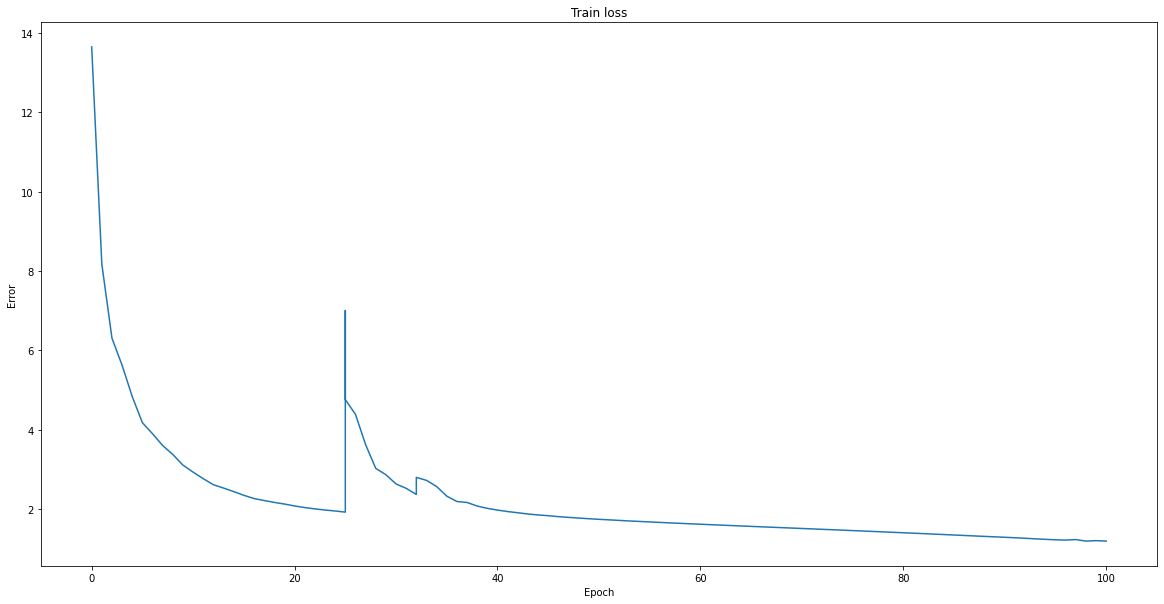

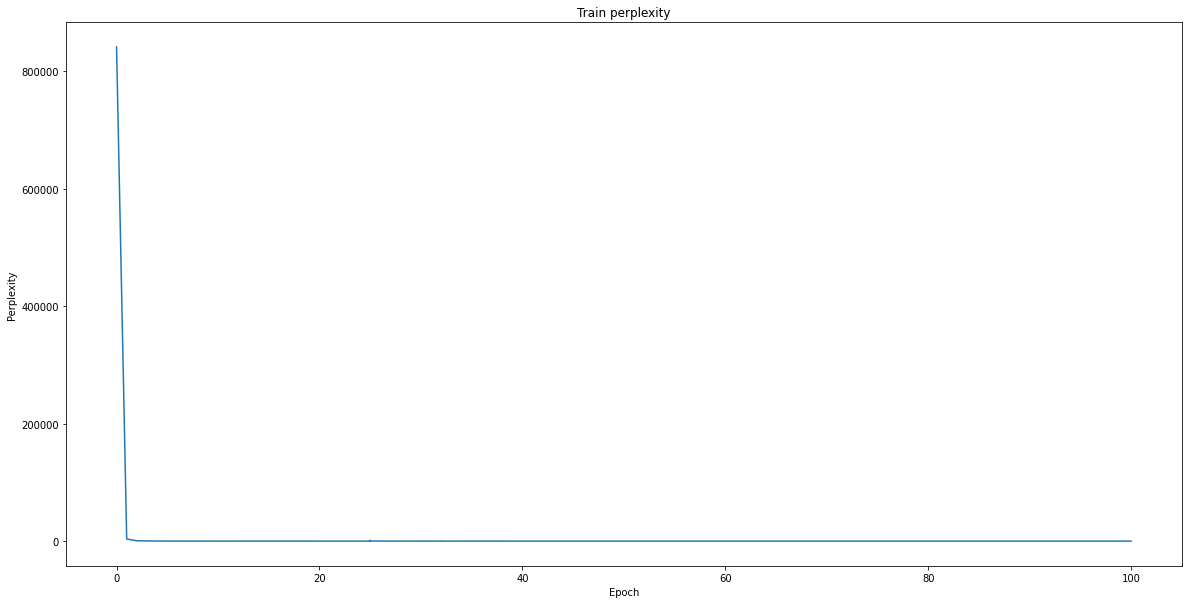

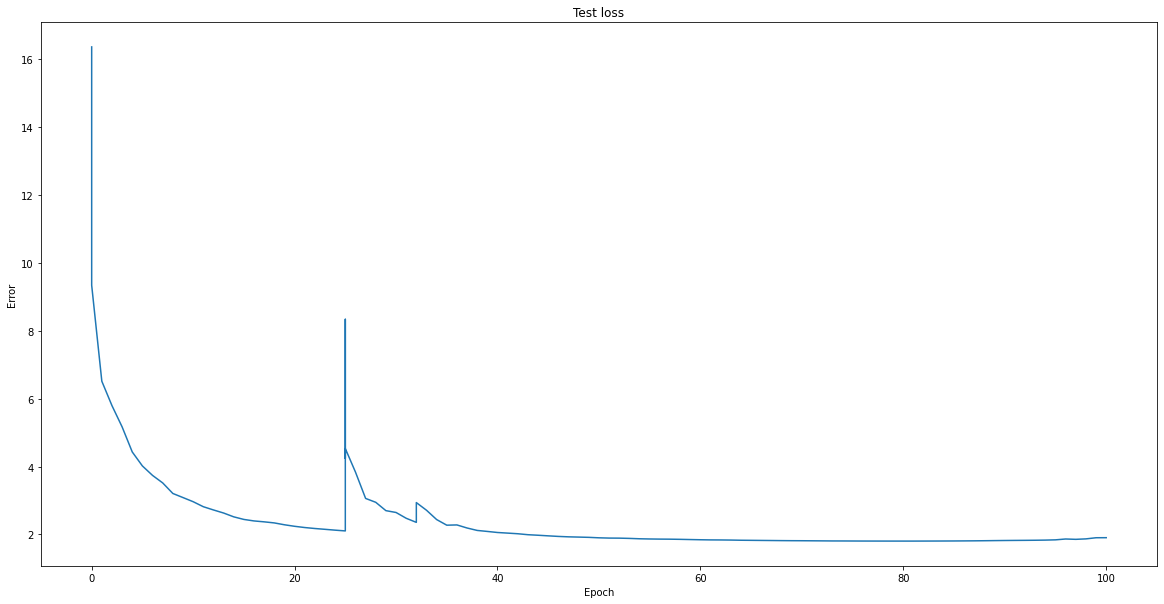

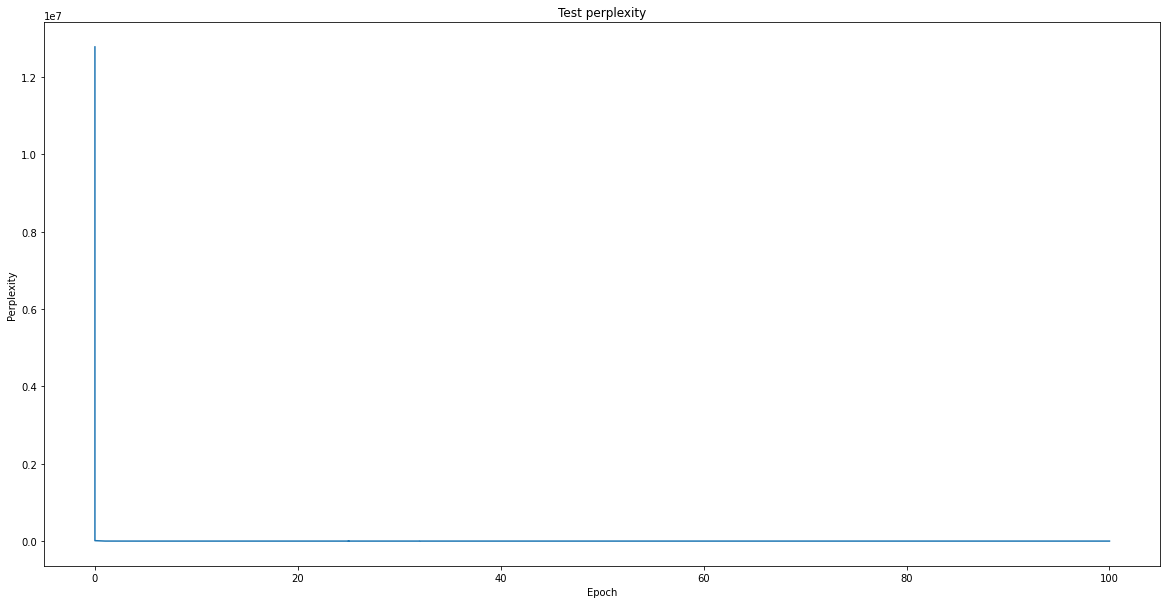

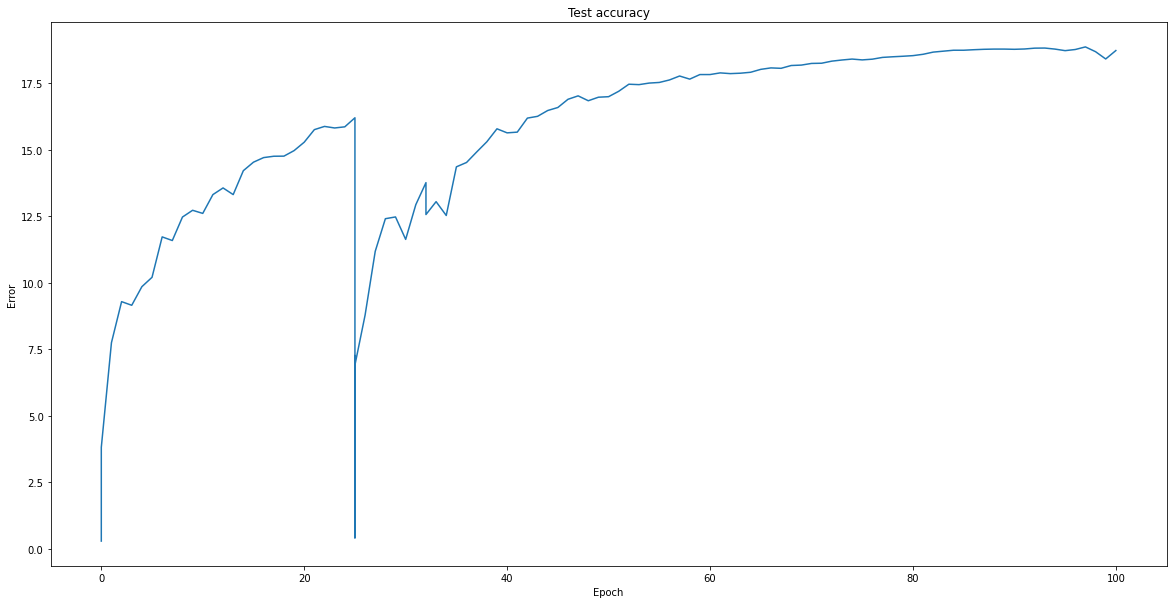

Final test accuracy: 18.73046875
Final test perplexity: 6.7058239406776865


In [41]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 100
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/beemovie/' + VERSION + '/'

    data_train = HarryPotterDataset(DATA_PATH + 'beemovie_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'beemovie_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'According to all known laws of aviation, '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

In [42]:
def eval_final_model(model, vocab, device):
    seed_words = 'Yellow, black'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Yellow, black. You don't know what to the stick our honey for the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free the bees! Free t
generated with sample	 Yellow, black. You don't know how mar ming! Wow! I love to go on? The bees! I the honey of the bee come of need make one of the bees! Free to go to look at to do more the bees! The lot of the bees! Free the ensome
generated with sample	 Yellow, black. You don't know. I work for the nocest of the bee joke? I don't know what I think of the bees! Free to more donesson read of the world out. Oome of the bees! Free the human race of the honey for the 
generated with sample	 Yellow, black. You know, I could say a could out out to do stay some of the honey fie have or could stopy that a could he out. - So you courting, son. I fellower pollen Jocks ours! Sting to to be a bee to look for
generated with sample	 Yellow, black it a looking our o

## 8.6 Words

In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.toLowercase()
    data = re.sub(r'[\r\n\t\s]+',' ', data).split()

    voc2ind = {}
    i = 0

    counts = {}
    for word in data:
        if word not in counts:
            counts[word] = 0
        counts[word] += 1

    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for word in counts:
        if word not in voc2ind and counts[word] >= 5:
            voc2ind[word] = i
            i += 1
    voc2ind[''] = i
    
    print('Size of vocabulary: {}'.format(len(voc2ind)))

    train_size = int(len(data) * 0.8)

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = data[:train_size]
    test_text = data[train_size:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')

class WordVocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind[''] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

Size of word vocabulary: 14403


In [ ]:
class HarryPotterWordDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterWordDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = WordVocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        tokens = dataset['tokens']
        voc2ind = dataset['voc2ind']

        n = len(tokens) - (len(tokens) % batch_size)
        self.data = torch.LongTensor([voc2ind[tokens[i]] if tokens[i] in voc2ind else voc2ind[''] for i in range(n)]).view(batch_size, -1)
        self.len = self.data.shape[0] * int(np.ceil((self.data.shape[1] - 1) / self.sequence_length))

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.len
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch_idx = idx % self.batch_size
        seq_idx = idx // self.batch_size

        seq_start_idx = seq_idx * self.sequence_length
        seq_end_idx = min(seq_start_idx + self.sequence_length + 1, self.data.shape[1])

        data = self.data[batch_idx][seq_start_idx:seq_end_idx]
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([14403, 1024]) = 58MB
gru.weight_ih_l0 -> 	torch.Size([3072, 1024]) = 12MB
gru.weight_hh_l0 -> 	torch.Size([3072, 1024]) = 12MB
gru.bias_ih_l0 -> 	torch.Size([3072]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([3072]) = 0MB
decoder.weight -> 	torch.Size([14403, 1024]) = 58MB
decoder.bias -> 	torch.Size([14403]) = 0MB

Restored all variables
No new variables
Restored /content/logs/0.1/020.pt
Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around t

  3%|▎         | 1/35 [00:01<00:37,  1.10s/it]

Train Epoch: 20 [0/8960 (0%)]	Loss: 5.639272


 31%|███▏      | 11/35 [00:11<00:25,  1.06s/it]

Train Epoch: 20 [2560/8960 (29%)]	Loss: 6.304696


 60%|██████    | 21/35 [00:22<00:15,  1.09s/it]

Train Epoch: 20 [5120/8960 (57%)]	Loss: 5.888087


 89%|████████▊ | 31/35 [00:33<00:04,  1.10s/it]

Train Epoch: 20 [7680/8960 (86%)]	Loss: 5.763630


100%|██████████| 35/35 [00:36<00:00,  1.06s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	in than t

  3%|▎         | 1/35 [00:01<00:38,  1.13s/it]

Train Epoch: 21 [0/8960 (0%)]	Loss: 5.607122


 31%|███▏      | 11/35 [00:11<00:25,  1.08s/it]

Train Epoch: 21 [2560/8960 (29%)]	Loss: 5.657916


 60%|██████    | 21/35 [00:22<00:14,  1.06s/it]

Train Epoch: 21 [5120/8960 (57%)]	Loss: 5.618582


 89%|████████▊ | 31/35 [00:32<00:04,  1.06s/it]

Train Epoch: 21 [7680/8960 (86%)]	Loss: 5.627917


100%|██████████| 35/35 [00:36<00:00,  1.04s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a than to

  3%|▎         | 1/35 [00:01<00:38,  1.12s/it]

Train Epoch: 22 [0/8960 (0%)]	Loss: 5.549222


 31%|███▏      | 11/35 [00:11<00:25,  1.07s/it]

Train Epoch: 22 [2560/8960 (29%)]	Loss: 5.615065


 60%|██████    | 21/35 [00:22<00:15,  1.07s/it]

Train Epoch: 22 [5120/8960 (57%)]	Loss: 5.588655


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 22 [7680/8960 (86%)]	Loss: 5.601213


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

  3%|▎         | 1/35 [00:01<00:38,  1.14s/it]

Train Epoch: 23 [0/8960 (0%)]	Loss: 5.539219


 31%|███▏      | 11/35 [00:11<00:25,  1.08s/it]

Train Epoch: 23 [2560/8960 (29%)]	Loss: 5.599030


 60%|██████    | 21/35 [00:22<00:14,  1.07s/it]

Train Epoch: 23 [5120/8960 (57%)]	Loss: 5.572726


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 23 [7680/8960 (86%)]	Loss: 5.580440


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

  3%|▎         | 1/35 [00:01<00:38,  1.14s/it]

Train Epoch: 24 [0/8960 (0%)]	Loss: 5.527046


 31%|███▏      | 11/35 [00:11<00:25,  1.06s/it]

Train Epoch: 24 [2560/8960 (29%)]	Loss: 5.581510


 60%|██████    | 21/35 [00:22<00:15,  1.08s/it]

Train Epoch: 24 [5120/8960 (57%)]	Loss: 5.556294


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 24 [7680/8960 (86%)]	Loss: 5.564769


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

  3%|▎         | 1/35 [00:01<00:39,  1.15s/it]

Train Epoch: 25 [0/8960 (0%)]	Loss: 5.516789


 31%|███▏      | 11/35 [00:11<00:25,  1.08s/it]

Train Epoch: 25 [2560/8960 (29%)]	Loss: 5.563789


 60%|██████    | 21/35 [00:22<00:14,  1.07s/it]

Train Epoch: 25 [5120/8960 (57%)]	Loss: 5.541214


 89%|████████▊ | 31/35 [00:33<00:04,  1.07s/it]

Train Epoch: 25 [7680/8960 (86%)]	Loss: 5.547823


100%|██████████| 35/35 [00:36<00:00,  1.05s/it]


Input	him more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all
GT	more Inferi creeping towards him around the sides of  but he blinked and saw that  was  all was still, the darkness complete but for a few streetlamps and lit upper windows. 'We did it,  Harry whispered with  he suddenly realised that he had a searing stitch in his chest. 'We did it! We got the  Dumbledore staggered against him. For a moment, Harry thought that his  Apparition had thrown Dumbledore  then he saw his face, paler and  than ever in the distant light of a   are you all 
pred	a  to  th

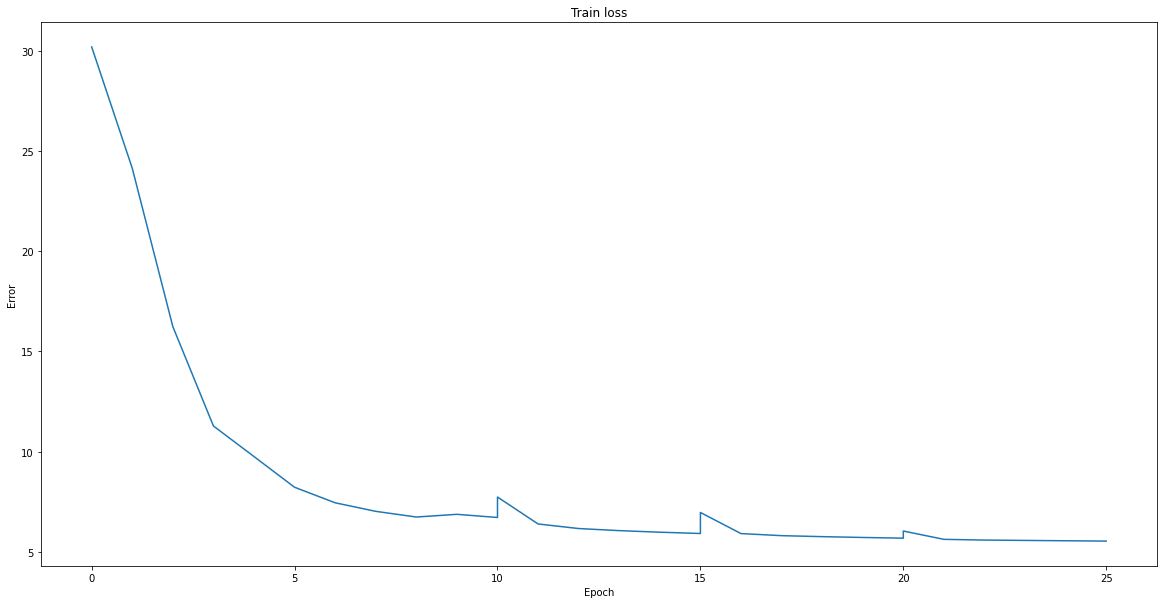

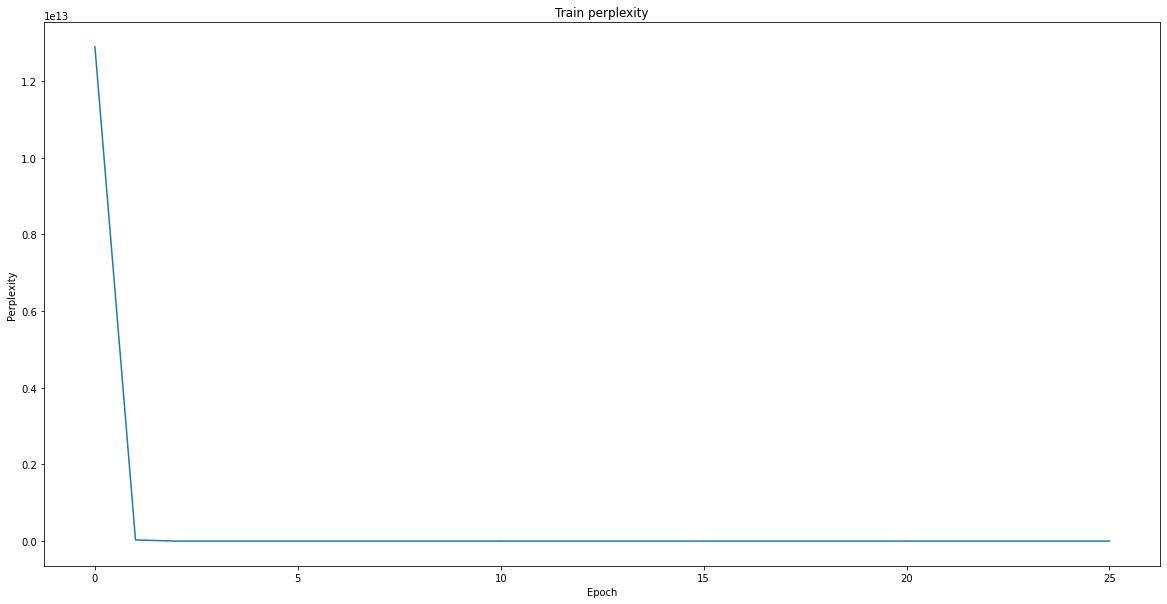

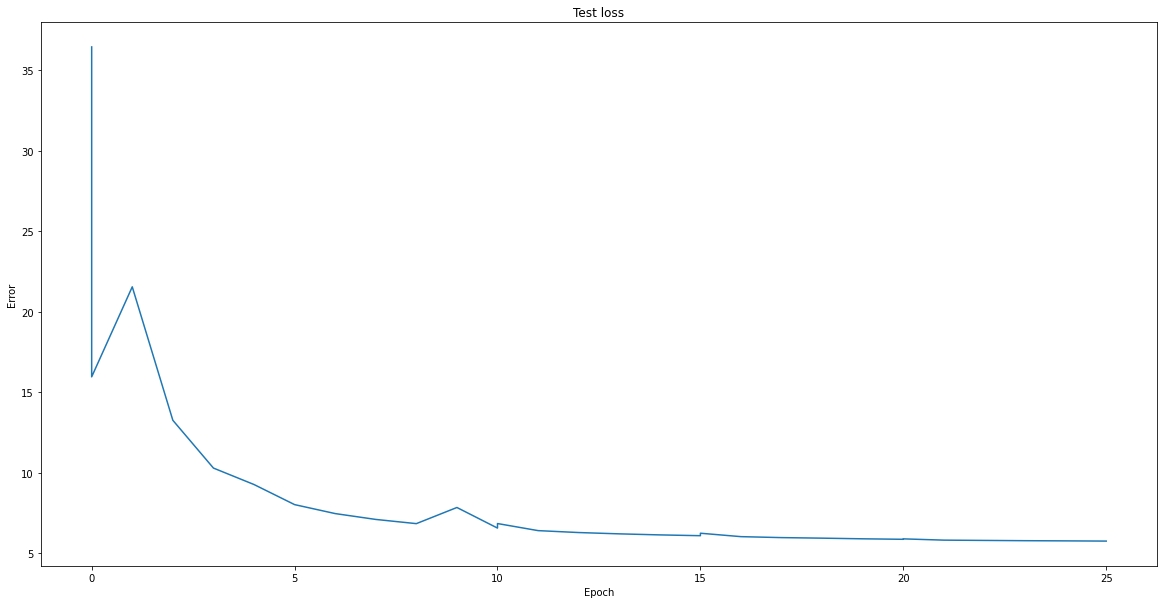

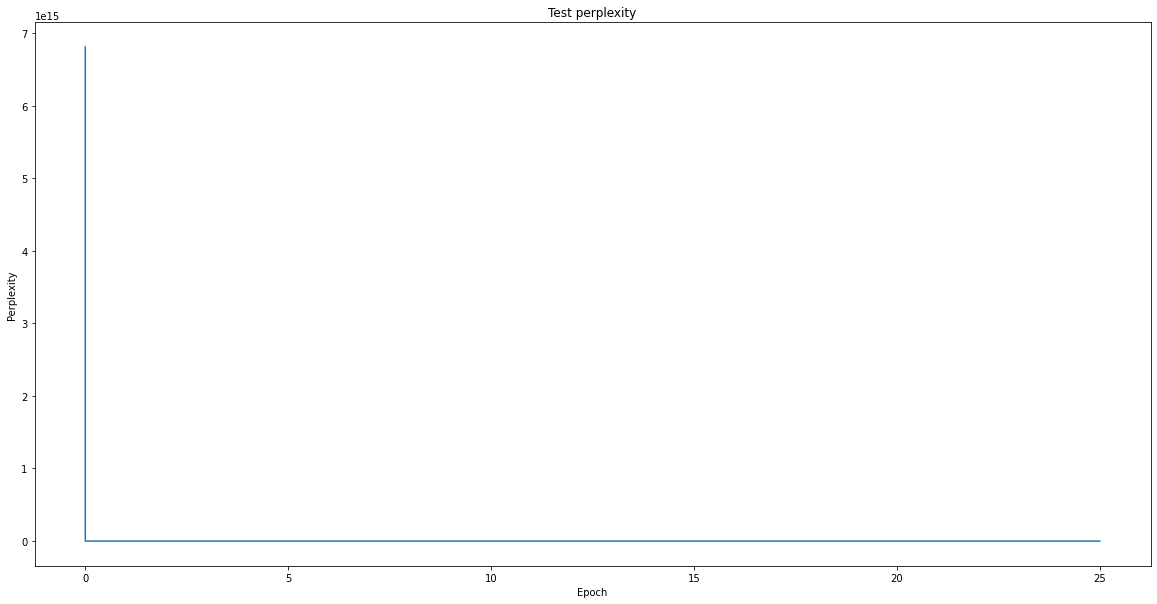

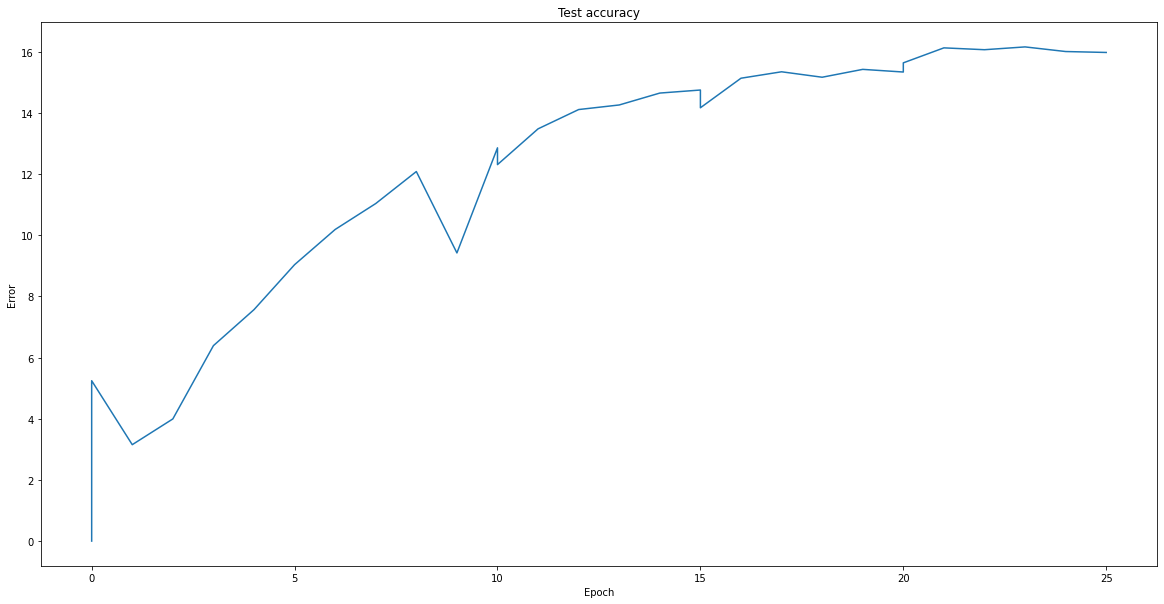

Final test accuracy: 15.972222222222221
Final test perplexity: 319.5617252260893


In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 1024
    TEST_BATCH_SIZE = 256
    EPOCHS = 25
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LEN = 20
    VERSION = '0.1'
    LOG_PATH = DATA_PATH + 'logs/' + VERSION + '/'

    data_train = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterWordDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '.split()
            generated_sentence = generate_language(model, device, seed_words, LEN, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, LEN, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, LEN, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        train_perplexity = np.exp(val)
        pt_util.plot(ep, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        test_perplexity = np.exp(val)
        pt_util.plot(ep, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
        print('Final test accuracy: {}'.format(test_accuracies[-1][1]))
        print('Final test perplexity: {}'.format(test_perplexity[-1]))
        return model, vocab, device

final_model, vocab, device = main()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    